# Second Run Scenarios: BAU and Restricted Transmission 

Author: Katie Shaw

Date: Tuesday Aug 26

Tests for BAU:
- is Hydrogen electrolysis limited to the amount considered?
- is carbon capture and sequestration equal to the amount considered 
- is the amount of flex right for 30% bev? 
- is the amount of flex right for 90% bev?
- is the amount of flex right for 25% additional water storage? (in the right place and the right amount)
- is the amount of flex right for 50% additional water storage? (in the right place and the right amount)
- is the amount of flex right for 75% additional water storage? (in the right place and the right amount)

Tests for restricted transmission:
- is Hydrogen electrolysis limited to the amount considered?
- is carbon capture and sequestration equal to the amount considered 
- is the amount of transmission less than the BAU case? and only 82% greater than the installed capacity! 
- is the amount of flex right for 30% bev? 
- is the amount of flex right for 90% bev?
- is the amount of flex right for 25% additional water storage? (in the right place and the right amount)
- is the amount of flex right for 50% additional water storage? (in the right place and the right amount)
- is the amount of flex right for 75% additional water storage? (in the right place and the right amount)



In [1]:
#Packages 
import pypsa
import matplotlib.pyplot as plt 
import cartopy 
import geopandas
import networkx
import linopy
import cartopy.crs as ccrs
import atlite 
import geopandas as gpd 
import xarray
import pandas as pd 
from datetime import datetime
import numpy as np
from pypsa.plot import add_legend_patches
import random
import plotly.graph_objects as go

## Overall view of colors matched to carriers 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

#importing auxillary functions
import Auxillary_Functions as af

In [ ]:
#functions to make tests: 
def hydrogen_electrolysis_limit_test(network, year):
    BAU_hydrogen_limits = {2020: 250, 2030: 40000, 2040: 425000, 2050: 550000} #this is in MW, the original dictionary in the configuration file is in MW

    print('Does a hydrogen limit exist?')
    if 'capacity_maximum-expansion-Europe-Link-H2-Electrolysis' in network.global_constraints.index:
        print('Yes')
        print('')

    print('does the hydrogen limit plus the installed capacity equal the limit in the configuration file?')
    installed_electrolysis_capacity = network.statistics()['Installed Capacity'].loc[('Link', 'H2 Electrolysis')]
    global_constraint_expansion_capacity = network.global_constraints['constant'].loc['capacity_maximum-expansion-Europe-Link-H2-Electrolysis']
    total = installed_electrolysis_capacity + global_constraint_expansion_capacity 
    if total - BAU_hydrogen_limits[year] < 2:
        print('Yes, constraint working and abided by')
        print('')

def carbon_sequestration_limit_test(network, year):
    BAU_Carbon_sequestration_limits = {2020: 0, 2030: 50, 2040: 280, 2050: 450}

    print('Does the Carbon sequestration limit exist?')
    if 'co2_sequestration_limit' in network.global_constraints.index:
        print('Yes')
    
    print('does the carbon sequestration amount is equal to the BAU appropriate configuration value')
    carbon_sequestration_limit = network.global_constraints['constant'].loc['co2_sequestration_limit']
    if carbon_sequestration_limit - BAU_Carbon_sequestration_limits[year] <= 1:
        print('Yes')
        print('')

def transmission_limit_test(network, year):
    transmission_limit = ('transmission_expansion_cost_limit' in network.global_constraints.type.unique())
    if transmission_limit:
        print('Yes, transmission limit exists')
    else:
        print('No transmission limit')
    
def carbon_constraint_check(network):
    carbon_constraint = network.global_constraints.loc['CO2Limit'].constant
    carbon_stores = network.stores_t.e['co2 atmosphere']['2019-12-31 18:00:00']
    
    if 'CO2Limit' in network.global_constraints.index:
        print('Carbon constraint exists')
    
    if (carbon_constraint - carbon_stores < 1):
        print('Yes, Carbon constraint abided by ')
    else:
        print('WARNING: Carbon constraint violated')

#curtailment options
def curtailment_dataframe_calculation(network):
#ok so this from make summaries isn't bad, but I want total mw hours and percentages, I understand if it's in percentages it doesn't matter because they cancel out but I want something new
        avail = (network.generators_t.p_max_pu.multiply(network.generators.p_nom_opt)
                .mul(network.snapshot_weightings.objective[0])#now it's in MWh -- power average over 6 hours times number of hours
                .sum() #sum of each potential dispatch at p_max_pu with p_nom_opt
                .groupby(network.generators.carrier)
                .sum()
        ) 
        avail
        used = (network.generators_t.p
                .mul(network.snapshot_weightings.objective[0]) #multiplying the average dispatch in MW over the 6 hour period by the time period, 6 hr 
                .sum()
                .groupby(network.generators.carrier)
                .sum()
        )
        curtailed_in_megawatthours = avail - used
        curtailed_in_megawatthours = curtailed_in_megawatthours[curtailed_in_megawatthours > 0]
        curtailed_in_megawatthours

        #relative to what would have been available from the wind or solar resource, so franction is related to available power as well? 
        curtailment_fraction = (avail - used) / avail * 100 #now it's in percentages
        curtailment_fraction = curtailment_fraction[curtailment_fraction >0] #to remove negative infinities form conventional generators
        curtailment_fraction = curtailment_fraction[curtailment_fraction < 110] # to remove positive infinity from heat vent
        curtailment_fraction

        curtailment_dataframe = pd.DataFrame()
        curtailment_dataframe['Curtailment in MWh'] = curtailed_in_megawatthours
        curtailment_dataframe['Curtailment Fraction (with respect to available power)'] = curtailment_fraction
        return curtailment_dataframe

def combine_with_suffixes(dfs, suffixes):
    """
    Combine multiple DataFrames with the same index,
    renaming their columns with the provided suffixes.

    Parameters
    ----------
    dfs : list of pd.DataFrame
        List of DataFrames to combine.
    suffixes : list of str
        List of suffix strings to apply to each DataFrame's columns.

    Returns
    -------
    combined : pd.DataFrame
        DataFrame with suffixed columns aligned by index.
    """
    if len(dfs) != len(suffixes):
        raise ValueError("Length of dfs and suffixes must match")

    renamed = [df.add_suffix(suf) for df, suf in zip(dfs, suffixes)]
    combined = pd.concat(renamed, axis=1)
    combined
    return combined




## BAU - no flex


In [124]:
BAU_no_flex_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU/BAU_no_flex/networks/base_s_39___2020.nc')
BAU_no_flex_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU/BAU_no_flex/networks/base_s_39___2030.nc')
BAU_no_flex_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU/BAU_no_flex/networks/base_s_39___2040.nc')
BAU_no_flex_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU/BAU_no_flex/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [125]:
#hydrogen limits test 
hydrogen_electrolysis_limit_test(BAU_no_flex_2020, 2020)
hydrogen_electrolysis_limit_test(BAU_no_flex_2030, 2030)
hydrogen_electrolysis_limit_test(BAU_no_flex_2040, 2040)
hydrogen_electrolysis_limit_test(BAU_no_flex_2050, 2050)


Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by



In [127]:
#Carbon tests
carbon_sequestration_limit_test(BAU_no_flex_2020, 2020)
carbon_sequestration_limit_test(BAU_no_flex_2030, 2030)
carbon_sequestration_limit_test(BAU_no_flex_2040, 2040)
carbon_sequestration_limit_test(BAU_no_flex_2050, 2050)

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes



In [128]:
#transmission limit 
transmission_limit_test(BAU_no_flex_2020, 2020)
transmission_limit_test(BAU_no_flex_2030, 2020)
transmission_limit_test(BAU_no_flex_2040, 2020)
transmission_limit_test(BAU_no_flex_2050, 2020)
#this is appropriate for the BAU scenario 

No transmission limit
No transmission limit
No transmission limit
No transmission limit


### Investigation of BAU Characteristics

In [ ]:
#BAU validation against ENTSO-E  -- functions to do the comparison
historic_entsoe_2020 = pd.read_csv(
    '/Users/katherine.shaw/Desktop/pypsa-eur/2020 entsoe-e/historical_electricity_production.csv',
    index_col=0,
    header=[0, 1],
    parse_dates=True,
)

subset_technologies = ["Geothermal", "Nuclear", "Biomass", "Lignite", "Oil", "Coal"]
lowercase_technologies = [
    technology.lower() if technology in subset_technologies else technology
    for technology in historic_entsoe_2020.columns.levels[1]
    ]
historic_entsoe_2020.columns = historic_entsoe_2020.columns.set_levels(lowercase_technologies, level=1)



def combine_series_by_dictionary(series1: pd.Series, series2: pd.Series, matched_data_dictionary: dict) -> pd.DataFrame:
    """
    Combines two pandas Series into a single DataFrame based on a dictionary
    that maps multiple source indices to a single target index.
    Values for matched source indices are summed under the target index.
    Rows in the series that do not match any dictionary values are ignored.

    Args:
        series1 (pd.Series): The first pandas Series.
        series2 (pd.Series): The second pandas Series.
        matched_data_dictionary (dict): A dictionary where keys are the
                                        desired new DataFrame indices, and
                                        values are lists of original indices
                                        to be mapped to that new index.

    Returns:
        pd.DataFrame: A DataFrame with the aggregated values under the new indices.
    """
    
    # Initialize a dictionary to store the aggregated data
    combined_data = {}

    # Iterate through the target indices and their corresponding source indices
    for target_index, source_indices_list in matched_data_dictionary.items():
        total_value_series1 = 0
        total_value_series2 = 0
        
        # Aggregate values for series1
        for source_index in source_indices_list:
            if source_index in series1.index:
                total_value_series1 += series1.loc[source_index]
        
        # Aggregate values for series2
        for source_index in source_indices_list:
            if source_index in series2.index:
                total_value_series2 += series2.loc[source_index]
        
        # Store the aggregated values for this target_index
        combined_data[target_index] = {
            'Series1_Value': total_value_series1,
            'Series2_Value': total_value_series2
        }
    
    # Create a DataFrame from the combined data
    # Orienting from_dict to 'index' makes the dictionary keys the DataFrame index
    df = pd.DataFrame.from_dict(combined_data, orient='index')
    
    # Ensure columns are properly named
    df.columns = ['Historic', 'Optimized']
    
    return df

matched_data_dictionary2 = {
    'Onshore Wind': ['Onshore Wind', 'onwind', 'onshore wind'],
    'Offshore Wind': ['Offshore Wind', 'Offshore Wind (AC)', 'Offshore Wind (DC)', 'Offshore Wind (Floating)', 'offwind-ac', 'offwind-dc', 'offwind-float', 'offshore wind'],
    'Solar' : ['Solar', 'solar-hsat', 'solar', 'solar rooftop'],
    'Nuclear': ['Nuclear', 'nuclear'], 
    'Run of River': ['Run of River', 'ror'],
    'Hydro': ['Hydro', 'hydro', 'PHS', 'Pumped Hydro Storage', 'Reservoir & Dam'],
    'Coal': ['Coal', 'coal'], 
    'Lignite': ['Lignite', 'lignite'],
    'Gas': ['Gas', 'gas', 'Combined-Cycle Gas', 'Open-Cycle Gas', 'CCGT', 'OCGT',  "urban central CHP", "urban central CHP CC"],
    'Geothermal': ['Geothermal', 'geothermal'],
    'Biomass': ['Biomass', 'solid biomass', 'urban central solid biomass CHP', 'urban central solid biomass CHP CC', 'biomass'],
    'Other': ['Other'],
    'Oil': ['oil', 'Oil']
    }
#To graph the result:
'''
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="y")
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show()
''' 



def electric_supply_from_the_sector_models(network_choice):
    #gets the total supply from the various carriers to the electric sector of the model, where applicable 
    ##the renewable generators connect directly to the AC buses 
    ## the conventional links deliver a certain amount of energy to the AC buses -- in the sector models the big loads are connected to the low voltage buses
  network = network_choice
  supply = {}

    #renewables 
  renewable_carriers = ['solar', 'offwind-dc', 'onwind',
       'offwind-ac', 'offwind-float', 'solar-hsat', 'ror', 'solar rooftop', 'hydro', 'ror', 'PHS']
      #generators 
  renewable_generators_by_carrier = network.generators[network.generators.carrier.isin(renewable_carriers)].index
  renewable_generators_by_carrier 
  renewables_dispatch = network.generators_t.p[renewable_generators_by_carrier]
  renewables_dispatch = renewables_dispatch.T
  renewables_dispatch=renewables_dispatch.groupby(network.generators.carrier).sum()
  renewables_dispatch = renewables_dispatch * network.snapshot_weightings.objective[0] #MW --> MWh 
  renewables_dispatch = renewables_dispatch.sum(axis=1)
    #low carbon carriers
  low_carbon_carriers = ['nuclear', 'geothermal']
  low_carbon_carriers = network.generators[network.generators.carrier.isin(low_carbon_carriers)].index
  low_carbon_dispatch = network.generators_t.p[low_carbon_carriers]
  low_carbon_dispatch = low_carbon_dispatch * network.snapshot_weightings.objective[0] #MW --> MWh
  low_carbon_dispatch = low_carbon_dispatch.T
  low_carbon_dispatch = low_carbon_dispatch.groupby(network.generators.carrier).sum()
  low_carbon_dispatch = low_carbon_dispatch.sum(axis=1)
  low_carbon_dispatch
    #conventional carriers = 
  conventional_carriers = ['coal', 'lignite', 'CCGT', 'OCGT', 'oil', "urban central solid biomass CHP", "urban central CHP", "urban central solid biomass CHP CC", "urban central CHP CC"] #biomass is technically low carbon, but CHP is given in links. biomass CHP only in urban central
  conventional_links = network.links[network.links.carrier.isin(conventional_carriers)].index
  conventional_links = network.links_t.p1[conventional_links]#power delivered to the end bus 
  conventional_links = conventional_links * network.snapshot_weightings.objective[0] * -1 #MW --> MWh, and multiplied by netgative one because contributing power to those buses
  conventional_links = conventional_links.T
  conventional_links = conventional_links.groupby(network.links.carrier).sum()
  conventional_links = conventional_links.sum(axis=1)
  conventional_links
  
  #hydro
  hydro_dispatch = network.storage_units_t.p.T.groupby(network.storage_units.carrier).sum().sum(axis=1) #storage units are just hydro and phs 
  hydro_dispatch = hydro_dispatch * network.snapshot_weightings.objective[0] #MW --> MWh



  dispatch_dict = {k: v for s in [renewables_dispatch, low_carbon_dispatch, conventional_links, hydro_dispatch] for k, v in s.items()}
  return dispatch_dict 



In [ ]:
#These functions create the bar chart with information about the renewable nature of the TWH produced in the whole sytem
def stacked_side_bar(network_choice):
    #to get rid of the depreciation warnings
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)

    network = network_choice
    #data from network
    renewable_carriers = ['solar', 'solar-hsat', 'onwind', 'offwind-ac', 'offwind-dc', 'offwind-float', 'hydro', 'solar rooftop', 'rural solar thermal', 'urban decentral solar thermal', 'urban central solar thermal', 'ror']
    renewable_generators = network.generators[network.generators.carrier.isin(renewable_carriers)].index 
    low_carbon_carriers = ['nuclear', 'geothermal']
    traditional_carriers = ['lignite', 'coal', 'oil primary', 'gas', 'biogas', 'solid biomass']

    renewable_production = (network.generators_t.p[renewable_generators] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
    low_carbon_production = (network.generators_t.p[(network.generators[network.generators.carrier.isin(low_carbon_carriers)].index)] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
    conventional_production =  (network.generators_t.p[(network.generators[network.generators.carrier.isin(traditional_carriers)].index)] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
 
    #hydro
    hydro_dispatch = network.storage_units_t.p.T.groupby(network.storage_units.carrier).sum().sum(axis=1) #storage units are just hydro and phs 
    hydro_dispatch = hydro_dispatch * network.snapshot_weightings.objective[0] #MW --> MWh

    # Your actual categories and summed values (replace these with your actual data if running)
    categories = ['Renewable', 'Low-Carbon', 'Conventional']
    values = [(renewable_production.sum() + hydro_dispatch.sum()), low_carbon_production.sum(), conventional_production.sum()]
    colors = ["#3B9357", "#799CAD", "#645744"]  # green, blue-gray, brown

    # Initialize plot
    fig, ax = plt.subplots(figsize=(10, 2.5))

    # Plot stacked horizontal bar
    left = 0
    bar_height = 0.6
    for val, color in zip(values, colors):
        ax.barh(y=0, width=val, left=left, height=bar_height,
                color=color, edgecolor='black', linewidth=1.5)
        left += val

    # Add labels with lines pointing to right-side annotations
    left = 0
    total = sum(values)
    right_edge_x = total  # <-- NEW: define rightmost edge of the bar

    for label, val in zip(categories, values):
        bar_center_x = left + val / 2
        segment_center_x = left + val / 2
        segment_centre_y = 0.10
        label_x = right_edge_x + 0.02 * total  # offset to the right
        label_y = 0.55  # vertical position of the label

        # Draw the connecting line
        ax.plot([bar_center_x, segment_center_x], [segment_centre_y, label_y - 0.15],
                color='black', linewidth=1.0)

        # Format value in scientific notation (rounded to 2 decimal places)
        sci_val = "{:.2e}".format(val)
        pct_val = f"{(val / total) * 100:.2f}"  # <-- FIXED: works for floats

        # Draw label and value
        ax.text(segment_center_x, label_y, label, ha='center', va='bottom', fontsize=10)
        ax.text(segment_center_x, label_y - 0.05, sci_val, ha='center', va='top', fontsize=9, color='gray')
        ax.text(segment_center_x, segment_centre_y - .2, pct_val + '%', ha='center', va='bottom', fontsize=9, color='k')

        left += val

    # Final plot adjustments
    ax.set_xlim(0, total * 1.15)
    ax.set_ylim(-0.5, 0.7)
    ax.set_yticks([])
    ax.set_xlabel("Generation [MWh]", fontsize=12)
    ax.set_title("Power Contribution by Technology Group", fontsize=14, pad=15)
    ax.spines[['top', 'right', 'left']].set_visible(False)
    #ax.grid(axis='x', linestyle='--', alpha=0.1)

    plt.tight_layout()
    plt.show()
    plt.close()
    return fig


def stacked_side_bar_electric(network_choice):
    #to get rid of the depreciation warnings
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)

    network = network_choice
    #data from network
   #data from network
    renewable_carriers = ['solar', 'solar-hsat', 'onwind', 'offwind-ac', 'offwind-dc', 'offwind-float', 'hydro', 'solar rooftop', 'ror'] #no solar thermal, though an argument could perhaps be made
    low_carbon_carriers = ['nuclear', 'geothermal']
    traditional_carriers = ['lignite', 'coal', 'oil primary', 'gas', 'biogas', 'solid biomass', ]

    #all buses that are acceptable 
    electric_buses = network.buses[network.buses.unit == 'MWh_el'].index #AC, battery, EV battery, low voltage, home battery 
    renewable_generators = network.generators[network.generators.carrier.isin(renewable_carriers)]
    renewable_generators = renewable_generators[renewable_generators.bus.isin(electric_buses)]
    renewable_generators = renewable_generators.index

    low_carbon_generators = network.generators[network.generators.carrier.isin(low_carbon_carriers)]
    low_carbon_generators = low_carbon_generators[low_carbon_generators.bus.isin(electric_buses)]
    low_carbon_generators = low_carbon_generators.index

    #conventional generators harder to nab, if I want to get to what was contributed to the power sector, have to take a different approach 
    conventional_generators = network.generators[network.generators.carrier.isin(traditional_carriers)]
    #conventional_generators = conventional_generators[conventional_generators.bus.isin(electric_buses)]
    #conventional_generators = conventional_generators.index 
    conventional_generators

    network.links.carrier.unique()
    #need all the links that come from a conventional bus and go into a electric bus
    thermal_to_power = network.links[network.links.bus1.isin(electric_buses)][~network.links.bus0.isin(electric_buses)]
    thermal_to_power = thermal_to_power[~(thermal_to_power.carrier == 'nuclear')]#get rid of all nuclear, because that is one I already have in low carbon power
    thermal_to_power = thermal_to_power.index 

    renewable_production = (network.generators_t.p[renewable_generators] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
    low_carbon_production = (network.generators_t.p[low_carbon_generators] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
    conventional_production =  (network.links_t.p1[thermal_to_power] * network.snapshot_weightings.objective[0]).T.groupby(network.links.carrier).sum().T.sum() #MWh
    conventional_production = conventional_production * -1 #because it's power delivered to the electric bus 

    #hydro
    hydro_dispatch = network.storage_units_t.p.T.groupby(network.storage_units.carrier).sum().sum(axis=1) #storage units are just hydro and phs 
    hydro_dispatch = hydro_dispatch * network.snapshot_weightings.objective[0] #MW --> MWh

    # Your actual categories and summed values (replace these with your actual data if running)
    categories = ['Renewable', 'Low-Carbon', 'Conventional']
    values = [(renewable_production.sum() + hydro_dispatch.sum()) , low_carbon_production.sum(), conventional_production.sum()]
    colors = ["#3B9357", "#799CAD", "#645744"]  # green, blue-gray, brown

    # Initialize plot
    fig, ax = plt.subplots(figsize=(10, 2.5))

    # Plot stacked horizontal bar
    left = 0
    bar_height = 0.6
    for val, color in zip(values, colors):
        ax.barh(y=0, width=val, left=left, height=bar_height,
                color=color, edgecolor='black', linewidth=1.5)
        left += val

    # Add labels with lines pointing to right-side annotations
    left = 0
    total = sum(values)
    right_edge_x = total  # <-- NEW: define rightmost edge of the bar
    for label, val in zip(categories, values):
        bar_center_x = left + val / 2
        segment_center_x = left + val / 2
        segment_centre_y = 0.10
        label_x = right_edge_x + 0.02 * total  # offset to the right
        label_y = 0.55  # vertical position of the label

        # Draw the connecting line
        ax.plot([bar_center_x,segment_center_x], [segment_centre_y, label_y - 0.15],
                color='black', linewidth=1.0)

        # Format value in scientific notation (rounded to 2 decimal places)
        sci_val = "{:.2e}".format(val)
        pct_val = str(((val/total) * 100).round(2))

        # Draw label and value
        ax.text(segment_center_x, label_y, label, ha='center', va='bottom', fontsize=10)
        ax.text(segment_center_x, label_y - 0.05, sci_val, ha='center', va='top', fontsize=9, color='gray')
        ax.text(segment_center_x, segment_centre_y - .2, pct_val + '%', ha = 'center', va = 'bottom', fontsize = 9, color = 'k')


        left += val

    # Final plot adjustments
    ax.set_xlim(0, total * 1.15)
    ax.set_ylim(-0.5, 0.7)
    ax.set_yticks([])
    ax.set_xlabel("Generation [MWh]", fontsize=12)
    ax.set_title("Power Contribution by Technology Group", fontsize=14, pad=15)
    ax.spines[['top', 'right', 'left']].set_visible(False)
    #ax.grid(axis='x', linestyle='--', alpha=0.1)

    plt.tight_layout()
    plt.show()
    plt.close()
    #return fig
    

Comparison to historic Entsoe-E data - whole sector and then refining to just power sector

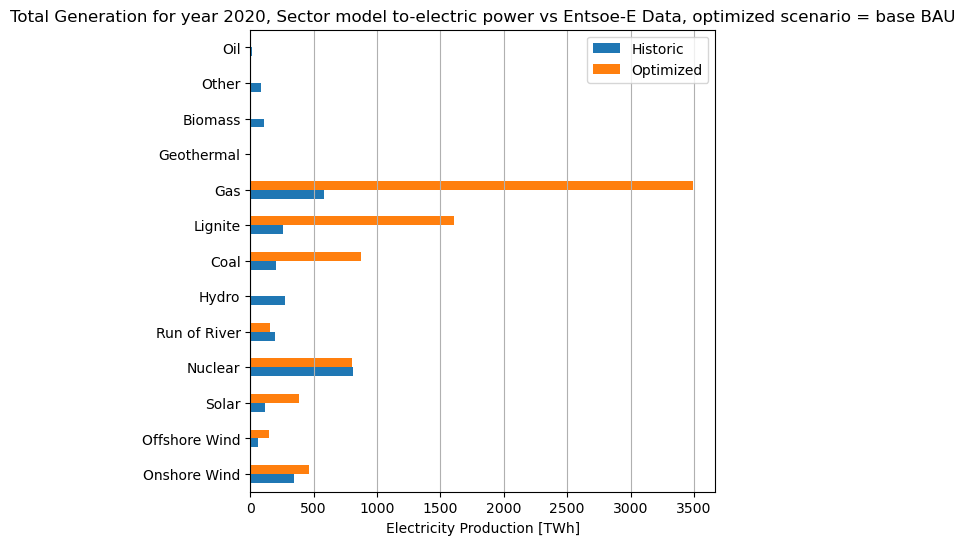

In [119]:
import warnings
# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), BAU_no_flex_2020.statistics().loc['Generator']['Supply'], matched_data_dictionary2)
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020, Sector model to-electric power vs Entsoe-E Data, optimized scenario = base BAU')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show() 

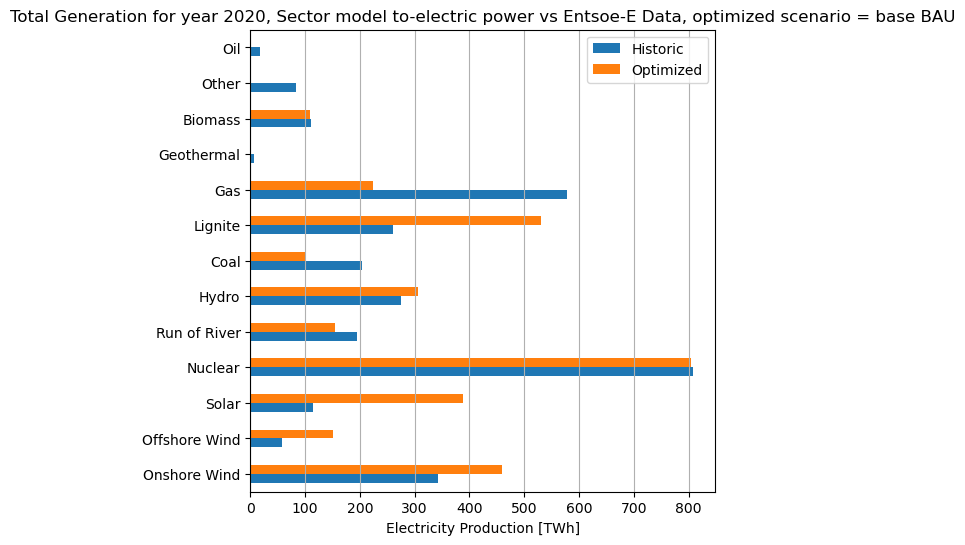

In [388]:
import warnings
# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), pd.Series(electric_supply_from_the_sector_models(BAU_no_flex_2020)), matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020, Sector model to-electric power vs Entsoe-E Data, optimized scenario = base BAU')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show()    

In [ ]:
f'{pd.Series(electric_supply_from_the_sector_models(BAU_no_flex_2020)).sum():.2e}' #total generation in MWh, to power sector

'3.23e+09'

In [ ]:
f'{historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1).sum():.2e}' #total generation in Mwh, from Entso-E

'3.05e+09'

network objective
2020 : 5.37e+11 
2030 : 4.59e+11 
2040 : 5.29e+11 
2050 : 1.27e+11 

system makeup -- all sectors
2020


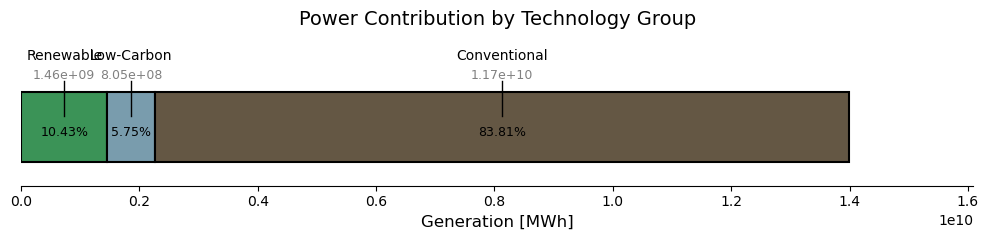

2030


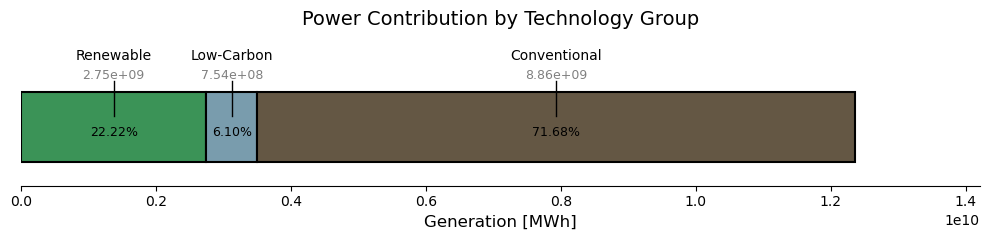

2040


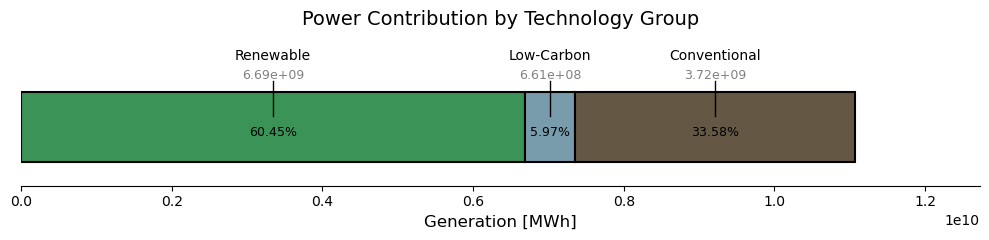

2050


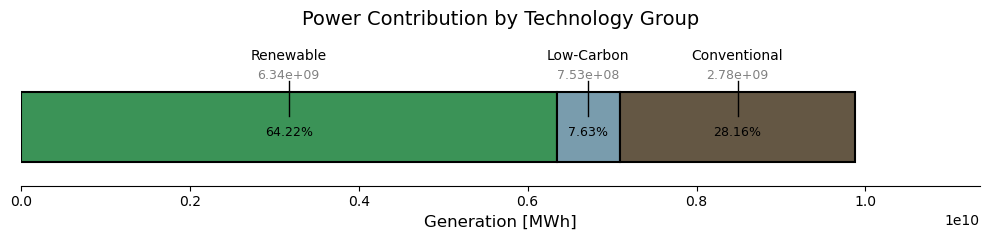

system makeup -- power sector
2020


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/3463980360.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



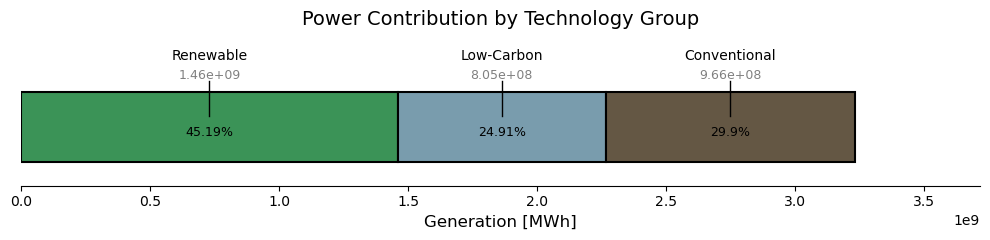

2030


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/3463980360.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



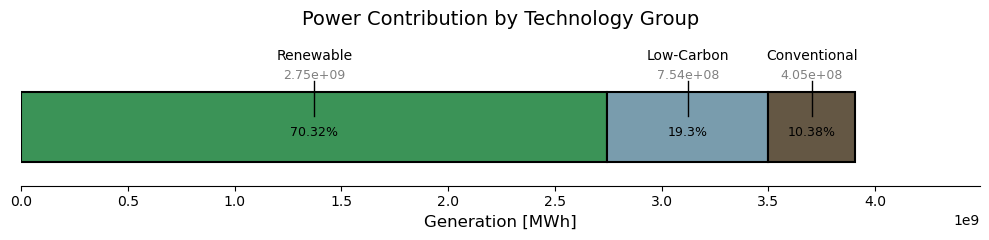

2040


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/3463980360.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



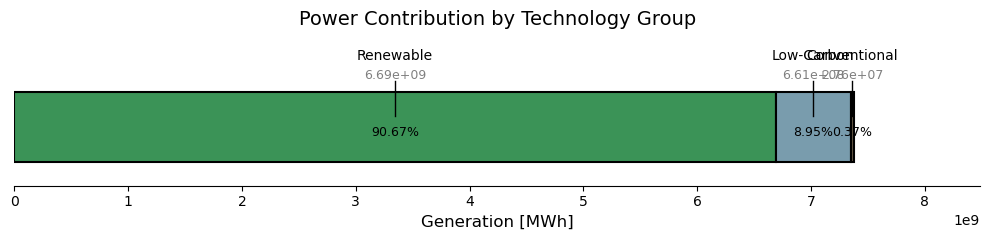

2050


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/3463980360.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



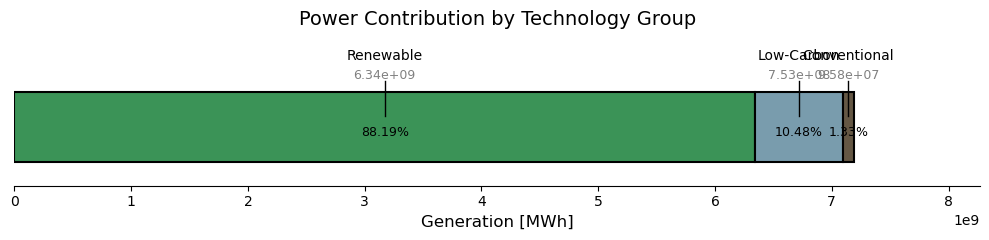

Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 


Curtailment in MWh_2020  \
carrier                                                  
offwind-ac                                5.242215e+04   
offwind-dc                                2.450147e+01   
offwind-float                             2.290516e+01   
onwind                                    9.759515e+06   
ror                                       9.521640e+02   
rural solar thermal                       1.907939e+01   
solar                                     1.671725e+05   
solar rooftop                             2.904365e+01   
solar-hsat                                3.611210e+01   
urban central heat vent                   3.014736e+02   
urban central solar thermal               1.686110e+01   
urban decentral solar thermal             1.813688e+01   

                               Curtailment Fraction (with respect to available power)_2020  \
carrier                                                                                      
offwind-ac                                                              0.034560             
offwind-dc                                                             30.280450             
offwind-float                                                          34.868794             
onwind                                                                  2.079572             
ror                                                                     0.000617             
rural solar thermal                                                    30.688509             
solar                                                                   0.050575             
solar rooftop                                                           0.000362             
solar-hsat                                                              0.000073             
urban central heat vent                                                      NaN             
urban central solar thermal                                            29.925209             
urban decentral solar thermal                                          22.193576             

                               Curtailment in MWh_2030  \
carrier                                                  
offwind-ac                                2.593656e+06   
offwind-dc                                6.023081e+02   
offwind-float                             1.893131e+01   
onwind                                    1.248451e+07   
ror                                       1.563996e+04   
rural solar thermal                       8.696716e+00   
solar                                     4.324896e+06   
solar rooftop                             5.267637e+06   
solar-hsat                                7.425836e+03   
urban central heat vent                   9.550196e+02   
urban central solar thermal               8.006099e+00   
urban decentral solar thermal             8.454233e+00   

                               Curtailment Fraction (with respect to available power)_2030  \
carrier                                                                                      
offwind-ac                                                              1.440196             
offwind-dc                                                              0.000314             
offwind-float                                                          24.181012             
onwind                                                                  1.286506             
ror                                                                     0.010131             
rural solar thermal                                                    31.676271             
solar                                                                   1.308422             
solar rooftop                                                           0.874016             
solar-hsat                                                              0.012041             
urban central heat vent                               

In [ ]:
#this function combines all the test functions above and 
BAU_no_flex_network_list = [BAU_no_flex_2020, BAU_no_flex_2030, BAU_no_flex_2040, BAU_no_flex_2050]

def network_list_summary(network_list):
    #overall cost of system
    print('network objective')
    print(
        f'2020 : {network_list[0].objective:.2e} \n'
        f'2030 : {network_list[1].objective:.2e} \n' 
        f'2040 : {network_list[2].objective:.2e} \n' 
        f'2050 : {network_list[3].objective:.2e} \n'
    )
    #system makeup - total 
    print('system makeup -- all sectors')
    print('2020')
    stacked_side_bar(network_list[0])
    print('2030')
    stacked_side_bar(network_list[1])
    print('2040')
    stacked_side_bar(network_list[2])
    print('2050')
    stacked_side_bar(network_list[3])
    #system makep - power sector 
    print('system makeup -- power sector')
    print('2020')
    stacked_side_bar_electric(network_list[0])
    print('2030')
    stacked_side_bar_electric(network_list[1])
    print('2040')
    stacked_side_bar_electric(network_list[2])
    print('2050')
    stacked_side_bar_electric(network_list[3])

    #hydrogen buildout 
    #carbon sequestered and overal carbon 
    [carbon_constraint_check(n) for n in BAU_no_flex_network_list]

network_list_summary(BAU_no_flex_network_list)
combine_with_suffixes(
    [curtailment_dataframe_calculation(s) for s in [BAU_no_flex_2020, BAU_no_flex_2030, BAU_no_flex_2040, BAU_no_flex_2050]],
    ['_2020', '_2030', '_2040', '_2050'])

In [326]:
print(BAU_no_flex_2040.stores_t.e['co2 atmosphere']['2019-12-31 18:00:00'])
print(BAU_no_flex_2040.global_constraints.loc['CO2Limit'].constant)


460391734.5032575
460391734.41315997


In [333]:
[carbon_constraint_check(n) for n in BAU_bev_30_network_list]

Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 


[None, None, None, None]

In [948]:
BAU_no_flex_2040.statistics().loc['Link'].loc['H2 Electrolysis']

Optimal Capacity           3.274815e+05
Installed Capacity         0.000000e+00
Supply                     1.449403e+09
Withdrawal                 2.070871e+09
Energy Balance            -6.214685e+08
Transmission               0.000000e+00
Capacity Factor            7.218753e-01
Curtailment                0.000000e+00
Capital Expenditure        4.944074e+10
Operational Expenditure    1.990656e+07
Revenue                    4.946064e+10
Market Value               3.412484e+01
Name: H2 Electrolysis, dtype: float64

## BAU - BEV 30% 


In [ ]:
BAU_bev_30_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU/BEV_30%/networks/base_s_39___2020.nc')
BAU_bev_30_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU/BEV_30%/networks/base_s_39___2030.nc')
BAU_bev_30_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU/BEV_30%/networks/base_s_39___2040.nc')
BAU_bev_30_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU/BEV_30%/networks/base_s_39___2050.nc')



INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [244]:
BAU_bev_30_network_list = [BAU_bev_30_2020, BAU_bev_30_2030, BAU_bev_30_2040, BAU_bev_30_2050 ]

In [ ]:
Flexibility_dataframe = pd.DataFrame()
Flexibility_dataframe.index = [2020, 2030, 2040, 2050]
Flexibility_dataframe['BEV - 30 pct'] = [s.stores[s.stores.carrier == 'EV battery'].e_nom.sum() for s in BAU_bev_30_network_list]
Flexibility_dataframe

BEV - 30 pct
2020           0.0
2030           0.0
2040           0.0
2050           0.0

#### Comparison between previous studies 

In [794]:
#how does BEV_30% compare to no flex regarding the metric we're interested in? 
#cost 
cost_dataframe = pd.DataFrame()
cost_dataframe.index = [2020, 2030, 2040, 2050]
cost_dataframe['BAU - no flex'] = [n.objective for n in BAU_no_flex_network_list]
cost_dataframe['BAU - BEV 30%'] = [n.objective for n in BAU_bev_30_network_list]
cost_dataframe#.style.background_gradient(cmap=plt.cm.Reds, axis = 1).format("{:.2e}")


BAU - no flex  BAU - BEV 30%
2020   5.374196e+11   5.374427e+11
2030   4.594736e+11   4.529459e+11
2040   5.292915e+11   5.167001e+11
2050   1.273244e+11   1.224237e+11

In [795]:
electric_supply_from_the_sector_models(BAU_no_flex_2020)

{'offwind-ac': 151630069.01529115,
 'offwind-dc': 56.413672080035056,
 'offwind-float': 42.78440875932753,
 'onwind': 459544602.1475568,
 'ror': 154379441.93386623,
 'solar': 330375749.1750391,
 'solar rooftop': 8018684.833118629,
 'solar-hsat': 49298786.85717423,
 'geothermal': 858477.8827912792,
 'nuclear': 804167552.8631717,
 'CCGT': 224000075.99937934,
 'OCGT': 70.79643730479876,
 'coal': 102356334.30293763,
 'lignite': 530218730.5721892,
 'oil': 16.577293613469934,
 'urban central CHP': 80.48166390478988,
 'urban central CHP CC': 52.25158213862439,
 'urban central solid biomass CHP': 109549664.68969065,
 'urban central solid biomass CHP CC': 30.107273502172678,
 'PHS': -4641371.444052491,
 'hydro': 311539625.6618705}

Not going to include solar thermal in solar becuase that connects directly to heat buses, and we're more inteseted in the ones connected to the power buses

In [ ]:
#how does BEV_30% compare to no flex regarding the metric we're interested in? CURTAILMENT FRACTION

curtailment_dataframe = pd.DataFrame()
curtailment_dataframe.index = [2020, 2030, 2040, 2050]
curtailment_dataframe['BAU - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['BAU - BEV 30%: wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in BAU_bev_30_network_list ]

curtailment_dataframe['BAU - no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['BAU - BEV 30%: solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in BAU_bev_30_network_list ]

curtailment_dataframe.style.background_gradient(cmap = plt.cm.Reds, axis =1 )

In [839]:
#how does BEV_30% compare to no flex regarding the metric we're interested in? CURTAILMENT in MWH
curtailment_dataframe = pd.DataFrame()
curtailment_dataframe.index = [2020, 2030, 2040, 2050]
curtailment_dataframe['BAU - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].sum() for s in BAU_no_flex_network_list ]
curtailment_dataframe['BAU - BEV 30%: wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].sum() for s in BAU_bev_30_network_list ]

curtailment_dataframe['BAU - no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar', 'solar rooftop', 'solar-hsat']].sum() for s in BAU_no_flex_network_list ]
curtailment_dataframe['BAU - BEV 30%: solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar', 'solar rooftop', 'solar-hsat']].sum() for s in BAU_bev_30_network_list ]

curtailment_dataframe.style.background_gradient(cmap = plt.cm.Reds, axis =1 ).format('{:.5e}')
#so even if it's an increase in the percentage curtailment hours like in wind or solar in 2030, it's a reduction of MWh overall

## BAU - BEV 90% 


In [935]:
## BAU - BEV 90% 

BAU_bev_90_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU/BEV_90%/networks/base_s_39___2020.nc')
BAU_bev_90_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU/BEV_90%/networks/base_s_39___2030.nc')
BAU_bev_90_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU/BEV_90%/networks/base_s_39___2040.nc')
BAU_bev_90_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU/BEV_90%/networks/base_s_39___2050.nc')


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [936]:
BAU_bev_90_network_list = [BAU_bev_90_2020,BAU_bev_90_2030,BAU_bev_90_2040,  BAU_bev_90_2050 ]
#comparison of BEV availability 
EV_store_size = pd.DataFrame()
EV_store_size.index = [ 2030, 2040, 2050]
EV_store_size['BEV_30%'] = [BAU_bev_30_network_list[1].stores[BAU_bev_30_network_list[1].stores.carrier == 'EV battery'].e_nom.sum(), BAU_bev_30_network_list[2].stores[BAU_bev_30_network_list[2].stores.carrier == 'EV battery'].e_nom.sum(), BAU_bev_30_network_list[3].stores[BAU_bev_30_network_list[3].stores.carrier == 'EV battery'].e_nom.sum()]
EV_store_size['BEV_90%'] = [BAU_bev_90_network_list[1].stores[BAU_bev_90_network_list[1].stores.carrier == 'EV battery'].e_nom.sum(), BAU_bev_90_network_list[2].stores[BAU_bev_90_network_list[2].stores.carrier == 'EV battery'].e_nom.sum(), BAU_bev_90_network_list[3].stores[BAU_bev_90_network_list[3].stores.carrier == 'EV battery'].e_nom.sum()]
EV_store_size

BEV_30%       BEV_90%
2030  1.314019e+06  3.942057e+06
2040  3.066044e+06  9.198133e+06
2050  4.380063e+06  1.314019e+07

In [937]:
BAU_bev_90_2040.global_constraints #constraints are operating as expected

type  \
GlobalConstraint                                                        
CO2Limit                                               co2_atmosphere   
co2_sequestration_limit                             operational_limit   
capacity_maximum-expansion-Europe-Link-H2-Elect...     capacity_limit   

                                                    investment_period  \
GlobalConstraint                                                        
CO2Limit                                                          NaN   
co2_sequestration_limit                                           NaN   
capacity_maximum-expansion-Europe-Link-H2-Elect...                NaN   

                                                   carrier_attribute sense  \
GlobalConstraint                                                             
CO2Limit                                               co2_emissions    <=   
co2_sequestration_limit                              co2 sequestered    >=   
capacity_maximum-expansion-Europe-Link-H2-Elect...                      <=   

                                                        constant          mu  
GlobalConstraint                                                              
CO2Limit                                            4.603917e+08 -386.288267  
co2_sequestration_limit                            -2.800000e+08  255.461220  
capacity_maximum-expansion-Europe-Link-H2-Elect...  4.250000e+05   -0.001509

In [938]:
#how does BEV_30% and BEV 90% compare to no flex regarding the metric we're interested in? CURTAILMENT FRACTION
#cost 
curtailment_dataframe = pd.DataFrame()
curtailment_dataframe.index = [2020, 2030, 2040, 2050]
curtailment_dataframe['BAU - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['BAU - BEV 30%: wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in BAU_bev_30_network_list ]
curtailment_dataframe['BAU - BEV 90%: wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in BAU_bev_90_network_list ]

curtailment_dataframe['BAU - no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar',  'solar rooftop', 'solar-hsat']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['BAU - BEV 30%: solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar',  'solar rooftop', 'solar-hsat']].mean() for s in BAU_bev_30_network_list ]
curtailment_dataframe['BAU - BEV 90%: solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'solar rooftop', 'solar-hsat']].mean() for s in BAU_bev_90_network_list ]


curtailment_dataframe.style.background_gradient(cmap = plt.cm.Reds, axis =1 )

In [939]:
#how does BEV_30% and BEV_90% compare to no flex regarding the metric we're interested in? Total CURTAILMENT in MWH for that type of renewables
curtailment_dataframe = pd.DataFrame()
curtailment_dataframe.index = [2020, 2030, 2040, 2050]
curtailment_dataframe['BAU - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].sum() for s in BAU_no_flex_network_list ]
curtailment_dataframe['BAU - BEV 30%: wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].sum() for s in BAU_bev_30_network_list ]
curtailment_dataframe['BAU - BEV 90%: wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].sum() for s in BAU_bev_90_network_list ]

curtailment_dataframe['BAU - no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar',  'solar rooftop', 'solar-hsat']].sum() for s in BAU_no_flex_network_list ]
curtailment_dataframe['BAU - BEV 30%: solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar',  'solar rooftop', 'solar-hsat']].sum() for s in BAU_bev_30_network_list ]
curtailment_dataframe['BAU - BEV 90%: solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar', 'solar rooftop', 'solar-hsat']].sum() for s in BAU_bev_90_network_list ]

curtailment_dataframe.style.background_gradient(cmap = plt.cm.Reds, axis =1 ).format('{:.3e}')
#so even if it's an increase in the percentage curtailment hours like in wind or solar in 2030, it's a reduction of MWh overall

In [940]:
#this function will tell us the difference in renewable buildout between the networks, which will help us understand the relative nature of the percentage comparison better
def renewables_optimal_capacity(network):
    renewable_capacity_series = network.statistics()['Optimal Capacity'].loc['Generator'].loc[['Offshore Wind (AC)', 'Offshore Wind (DC)', 'Offshore Wind (Floating)', 'Onshore Wind', 'Solar', 'solar rooftop', 'solar-hsat']]
    return renewable_capacity_series

#how does BEV_30% and BEV_90% compare to no flex regarding renewables buildout? in MWH
generation_dataframe = pd.DataFrame()
generation_dataframe['BAU - no flex : wind'] = [renewables_optimal_capacity(s).loc[['Offshore Wind (AC)', 'Offshore Wind (DC)', 'Offshore Wind (Floating)', 'Onshore Wind']].sum() for s in BAU_no_flex_network_list ]
generation_dataframe['BAU - BEV 30%: wind'] = [renewables_optimal_capacity(s).loc[['Offshore Wind (AC)', 'Offshore Wind (DC)', 'Offshore Wind (Floating)', 'Onshore Wind']].sum() for s in BAU_bev_30_network_list ]
generation_dataframe['BAU - BEV 90%: wind'] = [renewables_optimal_capacity(s).loc[['Offshore Wind (AC)', 'Offshore Wind (DC)', 'Offshore Wind (Floating)', 'Onshore Wind']].sum() for s in BAU_bev_90_network_list ]

generation_dataframe['BAU - no flex : solar'] = [renewables_optimal_capacity(s).loc[['Solar', 'solar rooftop', 'solar-hsat']].sum() for s in BAU_no_flex_network_list ]
generation_dataframe['BAU - BEV 30%: solar'] = [renewables_optimal_capacity(s).loc[['Solar', 'solar rooftop', 'solar-hsat']].sum() for s in BAU_bev_30_network_list ]
generation_dataframe['BAU - BEV 90%: solar'] = [renewables_optimal_capacity(s).loc[['Solar', 'solar rooftop', 'solar-hsat']].sum() for s in BAU_bev_90_network_list ]



In [941]:
generation_dataframe.style.background_gradient(cmap = plt.cm.Blues, axis =1).format('{:.3e}')

 ## BAU - additional heating (50% of homes)


In [847]:
BAU_heat_flex_med_level_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU/BAU_add_heat_flex_med_level_50.5m_homes/networks/base_s_39___2020.nc')
BAU_heat_flex_med_level_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU/BAU_add_heat_flex_med_level_50.5m_homes/networks/base_s_39___2030.nc')
BAU_heat_flex_med_level_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU/BAU_add_heat_flex_med_level_50.5m_homes/networks/base_s_39___2040.nc')
BAU_heat_flex_med_level_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU/BAU_add_heat_flex_med_level_50.5m_homes/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [849]:
BAU_heat_flex_med_network_list = [BAU_heat_flex_med_level_2020, BAU_heat_flex_med_level_2030, BAU_heat_flex_med_level_2040, BAU_heat_flex_med_level_2050  ]

In [848]:
#hydrogen limits test 
hydrogen_electrolysis_limit_test(BAU_heat_flex_med_level_2020, 2020)
hydrogen_electrolysis_limit_test(BAU_heat_flex_med_level_2030, 2030)
hydrogen_electrolysis_limit_test(BAU_heat_flex_med_level_2040, 2040)
hydrogen_electrolysis_limit_test(BAU_heat_flex_med_level_2050, 2050)
#Carbon tests
carbon_sequestration_limit_test(BAU_heat_flex_med_level_2020, 2020)
carbon_sequestration_limit_test(BAU_heat_flex_med_level_2030, 2030)
carbon_sequestration_limit_test(BAU_heat_flex_med_level_2040, 2040)
carbon_sequestration_limit_test(BAU_heat_flex_med_level_2050, 2050)
#carbon constraint check 
carbon_constraint_check(BAU_heat_flex_med_level_2020)
carbon_constraint_check(BAU_heat_flex_med_level_2030)
carbon_constraint_check(BAU_heat_flex_med_level_2040)
carbon_constraint_check(BAU_heat_flex_med_level_2050)

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Does the Carbon sequestration limit exist?
Yes

network objective
2020 : 5.37e+11 
2030 : 4.59e+11 
2040 : 5.29e+11 
2050 : 1.27e+11 

system makeup -- all sectors
2020


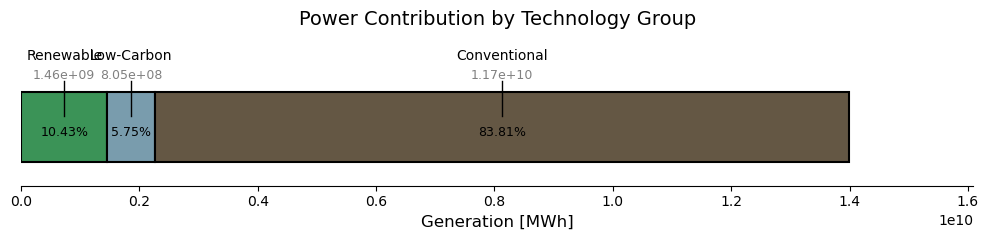

2030


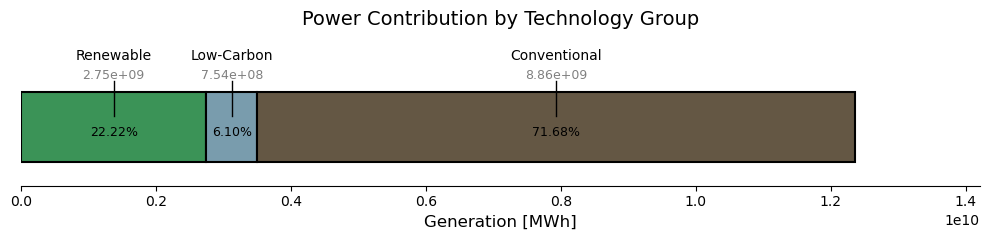

2040


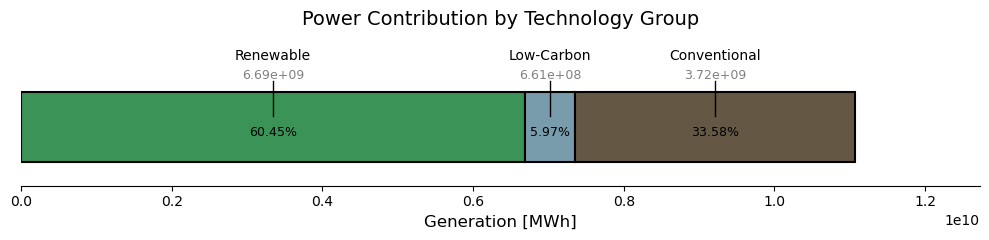

2050


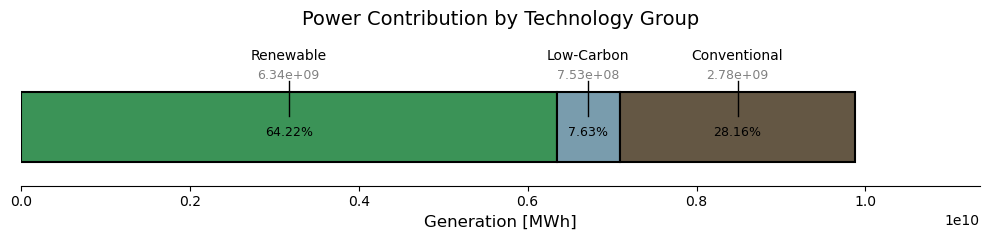

system makeup -- power sector
2020


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



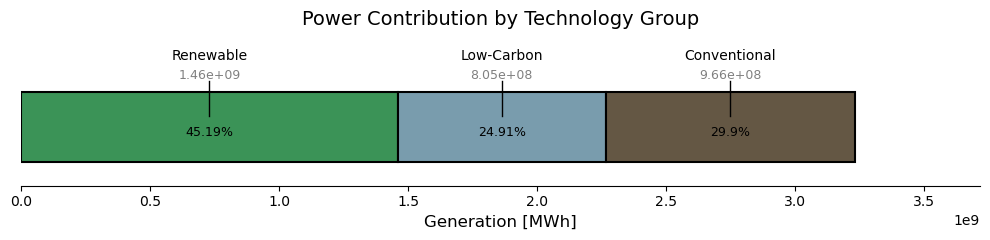

2030


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



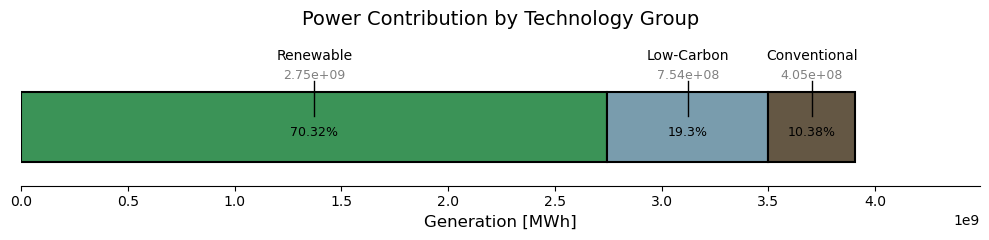

2040


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



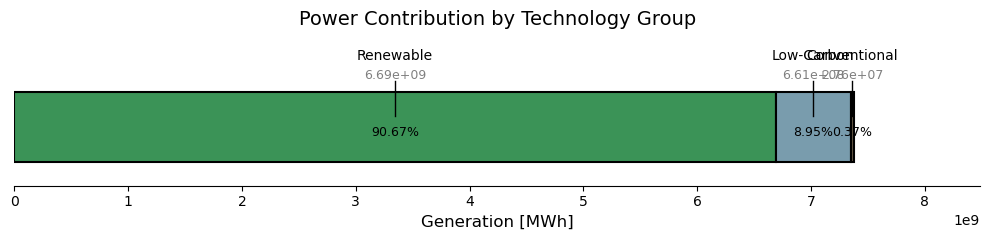

2050


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



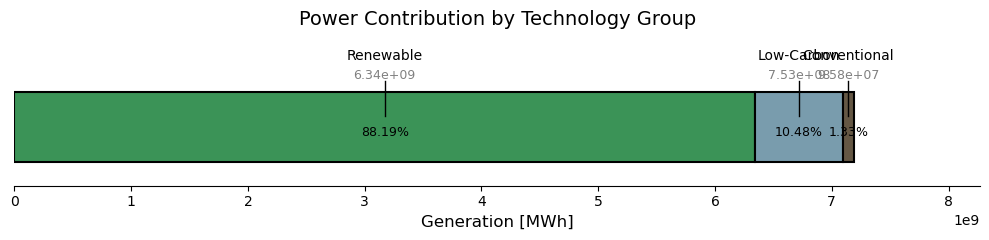

Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 


In [909]:
network_list_summary(BAU_no_flex_network_list) #WOW it's so much more conventional in the end compared to the other ones

network objective
2020 : 5.35e+11 
2030 : 4.57e+11 
2040 : 5.27e+11 
2050 : 1.25e+11 

system makeup -- all sectors
2020


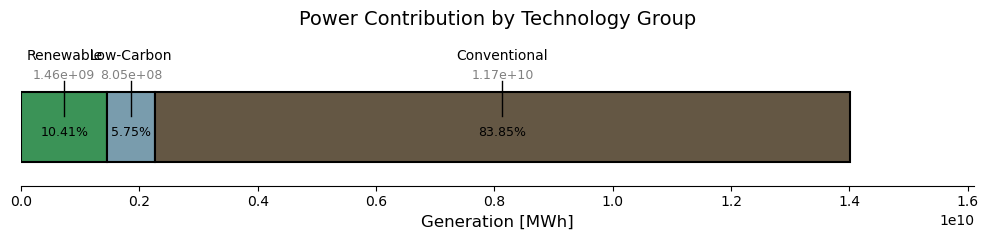

2030


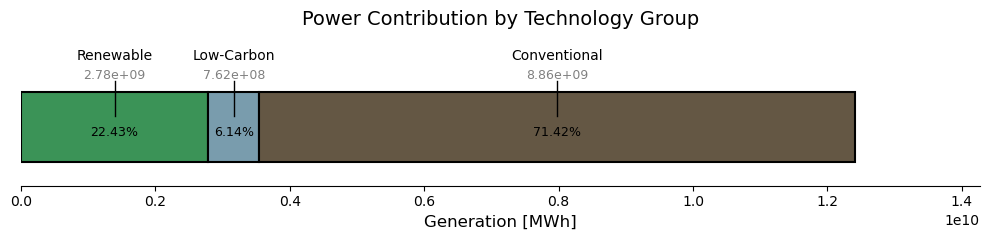

2040


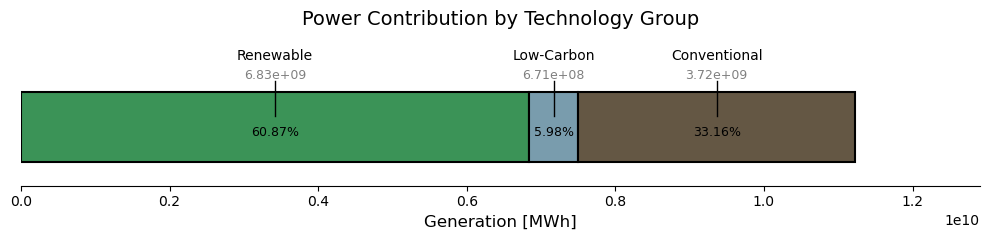

2050


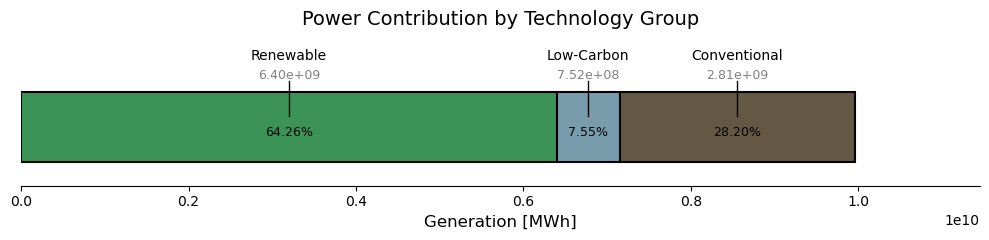

system makeup -- power sector
2020


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



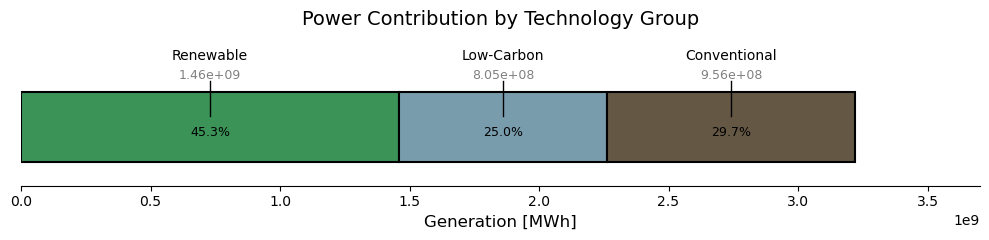

2030


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



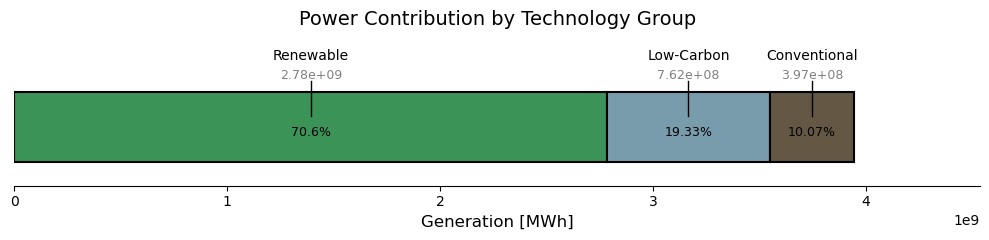

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



2040


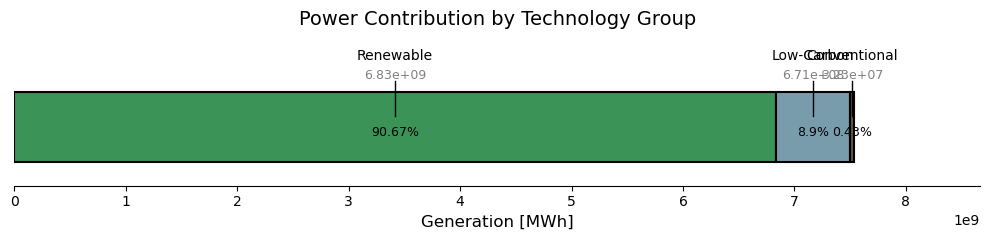

2050


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



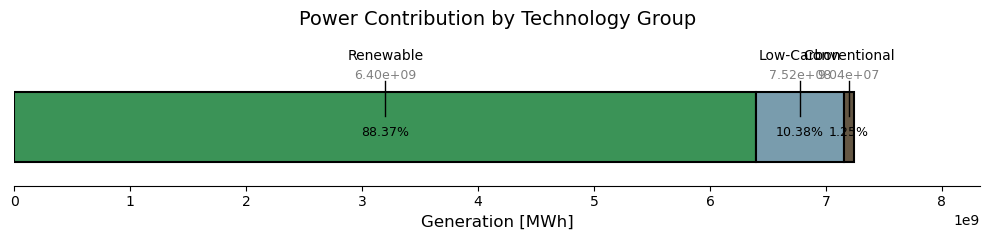

Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 


In [908]:
network_list_summary(BAU_heat_flex_med_network_list) #WOW it's so much more conventional in the end compared to the other ones

network objective
2020 : 5.35e+11 
2030 : 4.58e+11 
2040 : 6.59e+11 
2050 : 6.77e+10 

system makeup -- all sectors
2020


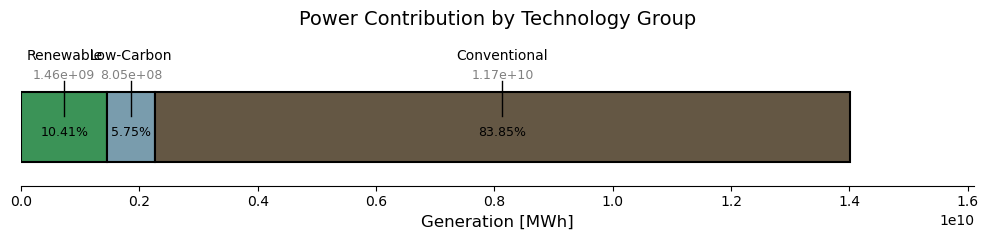

2030


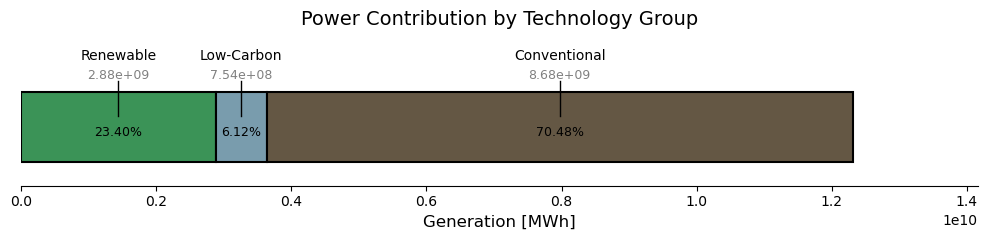

2040


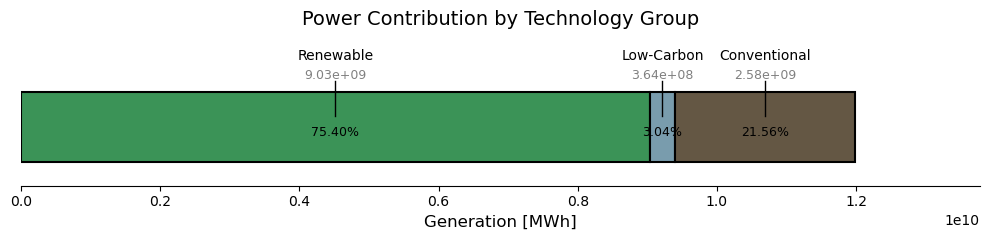

2050


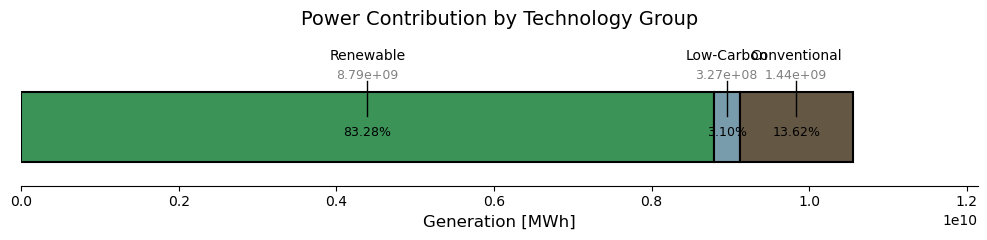

system makeup -- power sector
2020


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



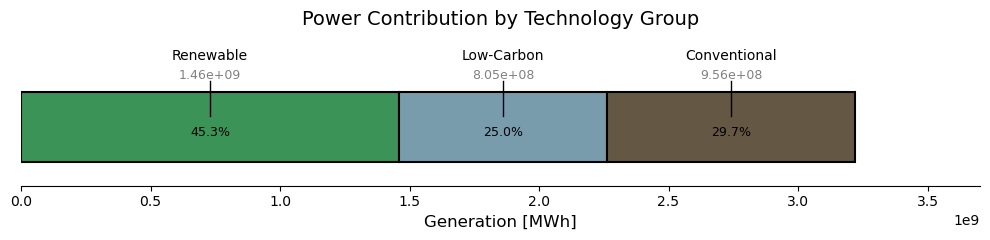

2030


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



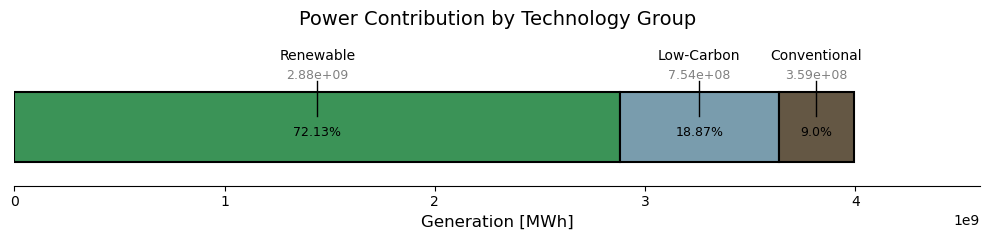

2040


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



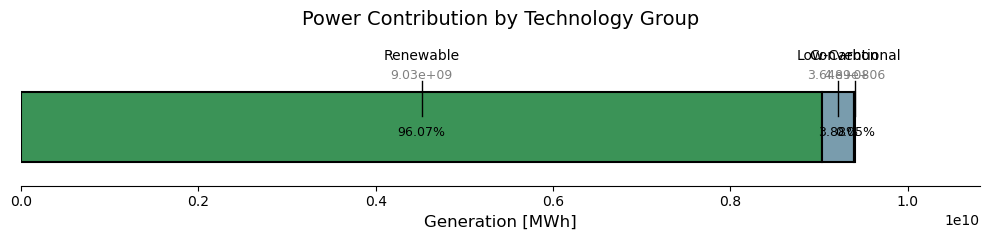

2050


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



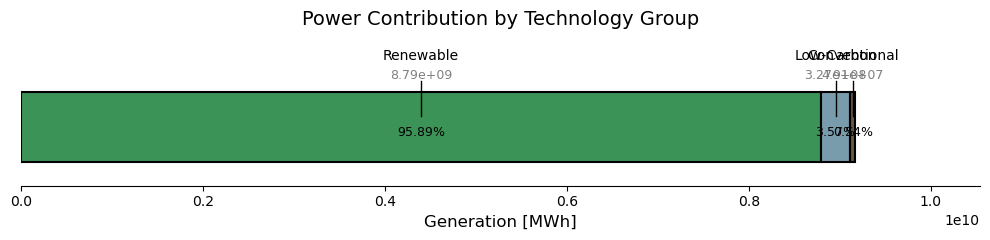

Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 


In [910]:
network_list_summary(CCUS_minimum_med_level_heat_flex_network_list) #WOW it's so much more conventional in the end compared to the other ones

In [ ]:
def heat_flex_energy_storage_additions(network):

In [861]:
BAU_heat_flex_med_level_2020.stores[BAU_heat_flex_med_level_2020.stores.index.str.contains('storage', case = False)]
number_homes = 50500000
size = 6 / 1000
number_homes * size

303000.0

# Changed Heating Function to be Proportional To Country, has it worked? 

heat_test_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/resources/networks/base_s_39___2020.nc')
heat_test_2020

In [929]:
#I expect that the total amount of storage is 0.006 * 25250000
0.006 * 25250000

151500.0

In [924]:
heat_test_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc')
heat_test_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2030.nc')
heat_test_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2040.nc')
heat_test_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2050.nc')


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [934]:
heat_test_2050.stores[heat_test_2050.stores.index.str.contains('storage', case = False)][heat_test_2050.stores.carrier == 'urban decentral water tanks'].e_nom.sum()

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1736188455.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



151499.99999999997


## BAU - additional heating (25% of homes)
 ## BAU - additional heating (50% of homes)
## BAU - additional heating (75% of homes)



# CCUS Minimum and Delays Networks 

## Minimum CCUS (0) for all years 

### No flex

In [297]:
CCUS_minimums_no_flex_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/CCUS Scenarios/CCUS minimum all years/CCUS minimum, no flex/networks/base_s_39___2020.nc')
CCUS_minimums_no_flex_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/CCUS Scenarios/CCUS minimum all years/CCUS minimum, no flex/networks/base_s_39___2030.nc')
CCUS_minimums_no_flex_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/CCUS Scenarios/CCUS minimum all years/CCUS minimum, no flex/networks/base_s_39___2040.nc')
CCUS_minimums_no_flex_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/CCUS Scenarios/CCUS minimum all years/CCUS minimum, no flex/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


network objective
2020 : 5.38e+11 
2030 : 4.59e+11 
2040 : 6.64e+11 
2050 : 7.05e+10 

system makeup -- all sectors
2020


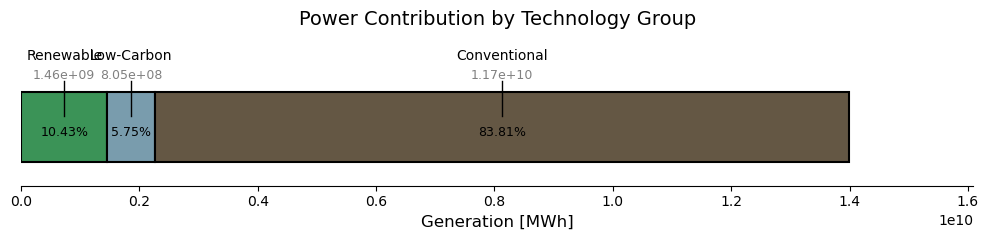

2030


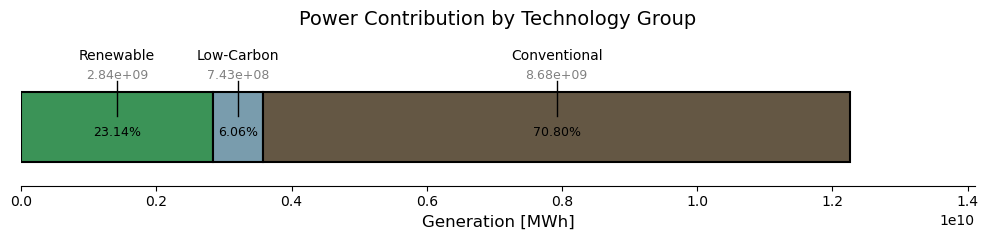

2040


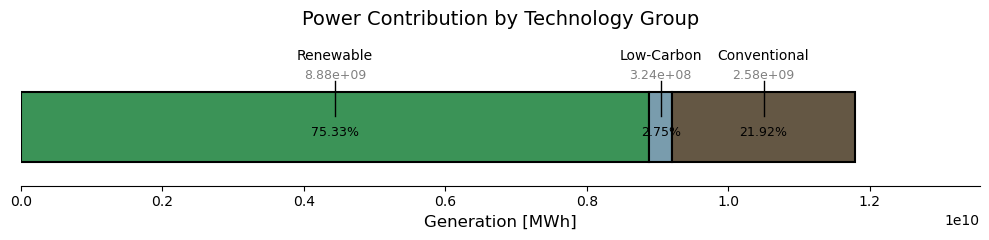

2050


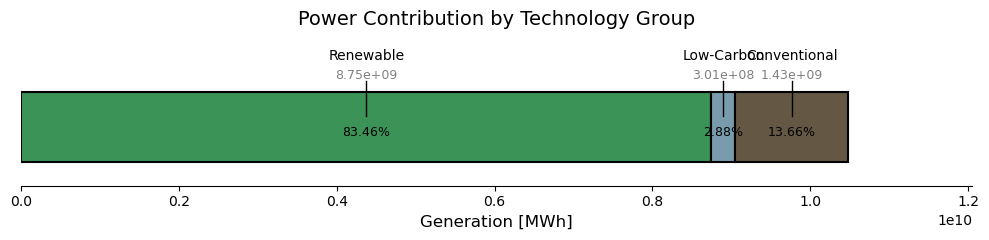

system makeup -- power sector
2020


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/3463980360.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



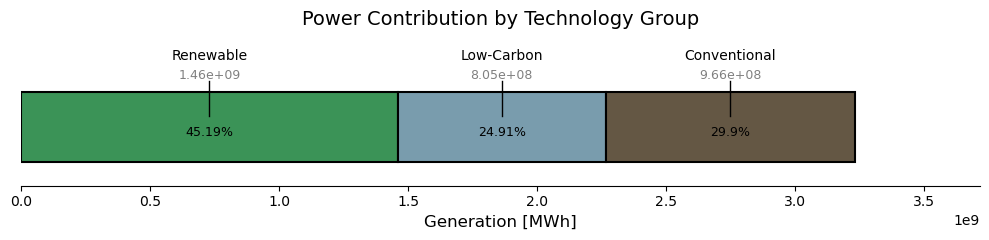

2030


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/3463980360.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



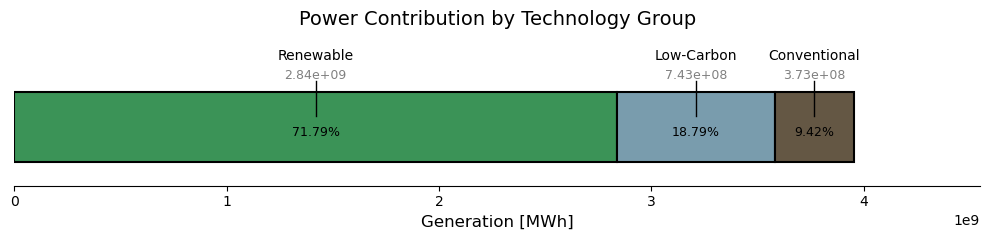

2040


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/3463980360.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



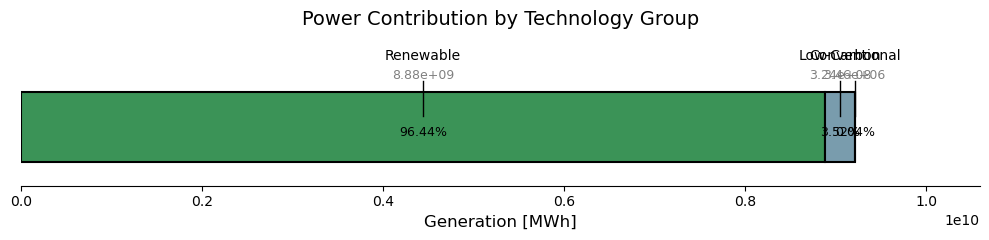

2050


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/3463980360.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



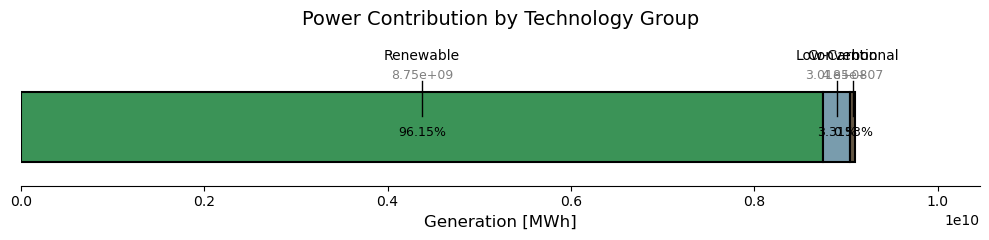

Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 


In [386]:
CCUS_minimum_no_flex = [CCUS_minimums_no_flex_2020, CCUS_minimums_no_flex_2030, CCUS_minimums_no_flex_2040, CCUS_minimums_no_flex_2050]
network_list_summary(CCUS_minimum_no_flex)

### Comparing to the BAU scenario

In [873]:
#how does BEV_30% compare to no flex regarding the metric we're interested in? 
#cost 
cost_dataframe = pd.DataFrame()
cost_dataframe.index = [2020, 2030, 2040, 2050]
cost_dataframe['BAU - no flex'] = [n.objective for n in BAU_no_flex_network_list]
cost_dataframe['CCUS minimum'] = [n.objective for n in CCUS_minimum_no_flex]
cost_dataframe.style.background_gradient(cmap = plt.cm.Blues, axis = 1).format("{:.5e}")

In [ ]:
electric_supply_from_the_sector_models(BAU)

<function __main__.electric_supply_from_the_sector_models(network_choice)>

In [ ]:
#how does BEV_30% compare to no flex regarding the metric we're interested in? CURTAILMENT FRACTION 
curtailment_dataframe = pd.DataFrame()
curtailment_dataframe.index = [2020, 2030, 2040, 2050]
curtailment_dataframe['BAU - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['CCUS min : wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in CCUS_minimum_no_flex ]

curtailment_dataframe['BAU - no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'rural solar thermal', 'solar rooftop', 'solar-hsat']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['CCUS min : solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'rural solar thermal', 'solar rooftop', 'solar-hsat']].mean() for s in CCUS_minimum_no_flex ]

curtailment_dataframe.style.background_gradient(cmap = plt.cm.Blues, axis = 1).format("{:.3e}")
#this is between BAU and CCUS minimums, which is why the numbers are so different

In [877]:
#how does BEV_30% compare to no flex regarding the metric we're interested in? CURTAILMENT in MWh 
curtailment_dataframe = pd.DataFrame()
curtailment_dataframe.index = [2020, 2030, 2040, 2050]
curtailment_dataframe['BAU - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['CCUS min : wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in CCUS_minimum_no_flex ]

curtailment_dataframe['BAU - no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar', 'rural solar thermal', 'solar rooftop', 'solar-hsat']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['CCUS min : solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar', 'rural solar thermal', 'solar rooftop', 'solar-hsat']].mean() for s in CCUS_minimum_no_flex ]

curtailment_dataframe.style.background_gradient(cmap = plt.cm.Blues, axis = 1).format("{:.3e}")
#so even if it's an increase in the percentage curtailment hours like in wind or solar in 2030, it's a reduction of MWh overall

In [879]:
#how does the generation built differ between BAU and CCUS minimums?
generation_dataframe = pd.DataFrame()
generation_dataframe['BAU - no flex : wind'] = [renewables_optimal_capacity(s).loc[['Offshore Wind (AC)', 'Offshore Wind (DC)', 'Offshore Wind (Floating)', 'Onshore Wind']].sum() for s in BAU_no_flex_network_list ]
generation_dataframe['CCUS min - no flex: wind'] = [renewables_optimal_capacity(s).loc[['Offshore Wind (AC)', 'Offshore Wind (DC)', 'Offshore Wind (Floating)', 'Onshore Wind']].sum() for s in CCUS_minimum_no_flex ]

generation_dataframe['BAU - no flex : solar'] = [renewables_optimal_capacity(s).loc[['Solar', 'solar rooftop', 'solar-hsat']].sum() for s in BAU_no_flex_network_list ]
generation_dataframe['CCUS min - no flex: solar'] = [renewables_optimal_capacity(s).loc[['Solar', 'solar rooftop', 'solar-hsat']].sum() for s in CCUS_minimum_no_flex ]

generation_dataframe.style.background_gradient(cmap = plt.cm.Blues, axis = 1).format("{:.3e}")


### BEV - 30% flex

In [400]:
CCUS_minimums_bev_30_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/CCUS Scenarios/CCUS minimum all years/CCUS minimum, bev_30%/networks/base_s_39___2020.nc')
CCUS_minimums_bev_30_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/CCUS Scenarios/CCUS minimum all years/CCUS minimum, bev_30%/networks/base_s_39___2030.nc')
CCUS_minimums_bev_30_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/CCUS Scenarios/CCUS minimum all years/CCUS minimum, bev_30%/networks/base_s_39___2040.nc')
CCUS_minimums_bev_30_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/CCUS Scenarios/CCUS minimum all years/CCUS minimum, bev_30%/networks/base_s_39___2050.nc')


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [401]:
CCUS_minimums_bev_30_network_list = [CCUS_minimums_bev_30_2020, CCUS_minimums_bev_30_2030, CCUS_minimums_bev_30_2040,CCUS_minimums_bev_30_2050 ]

In [403]:
#hydrogen limits test 
hydrogen_electrolysis_limit_test(CCUS_minimums_bev_30_2020, 2020)
hydrogen_electrolysis_limit_test(CCUS_minimums_bev_30_2030, 2030)
hydrogen_electrolysis_limit_test(CCUS_minimums_bev_30_2040, 2040)
hydrogen_electrolysis_limit_test(CCUS_minimums_bev_30_2050, 2050)

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by



In [518]:
#Carbon tests
carbon_sequestration_limit_test(CCUS_minimums_bev_30_2020, 2020)
carbon_sequestration_limit_test(CCUS_minimums_bev_30_2030, 2030)
carbon_sequestration_limit_test(CCUS_minimums_bev_30_2040, 2040)
carbon_sequestration_limit_test(CCUS_minimums_bev_30_2050, 2050)

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes



In [519]:
#transmission limit 
transmission_limit_test(CCUS_minimums_bev_30_2020, 2020)
transmission_limit_test(CCUS_minimums_bev_30_2030, 2020)
transmission_limit_test(CCUS_minimums_bev_30_2040, 2020)
transmission_limit_test(CCUS_minimums_bev_30_2050, 2020)
#this is appropriate for the BAU scenario 

No transmission limit
No transmission limit
No transmission limit
No transmission limit


network objective
2020 : 5.37e+11 
2030 : 4.53e+11 
2040 : 6.54e+11 
2050 : 6.57e+10 

system makeup -- all sectors
2020


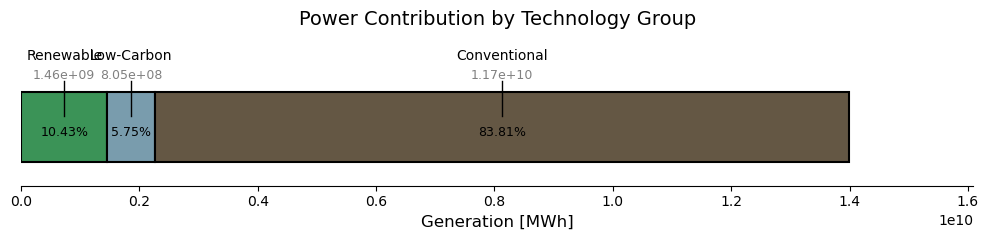

2030


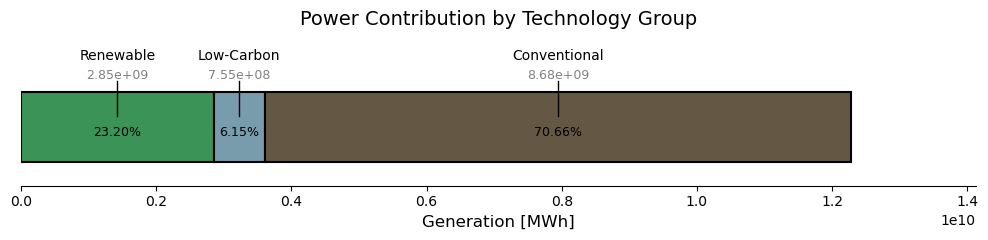

2040


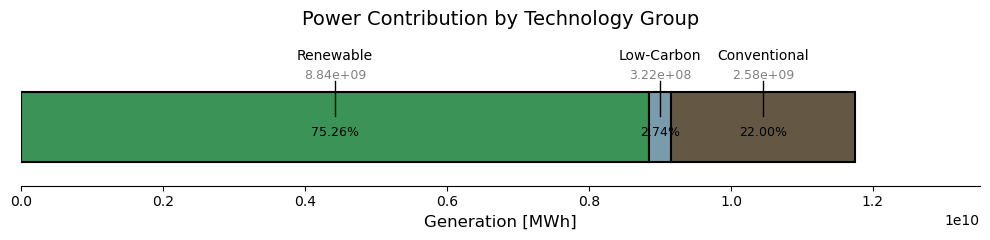

2050


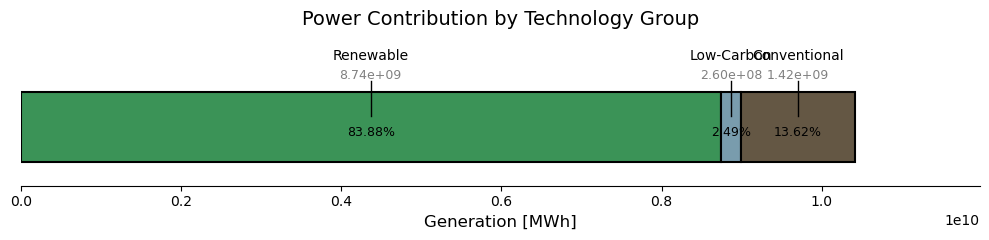

system makeup -- power sector
2020


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



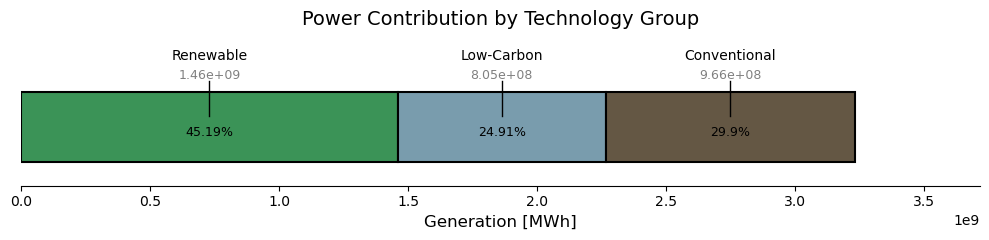

2030


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



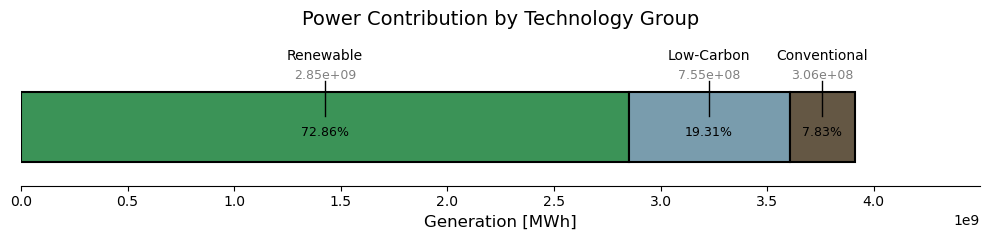

2040


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



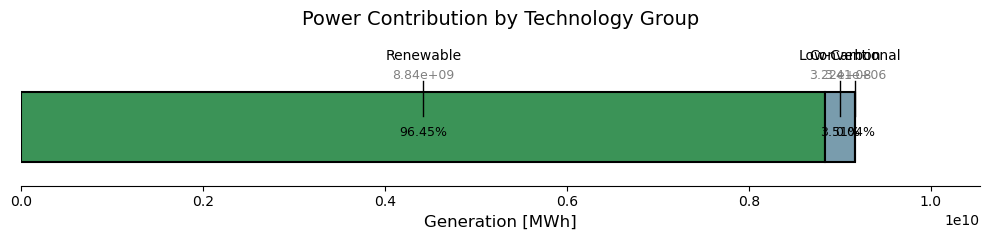

2050


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



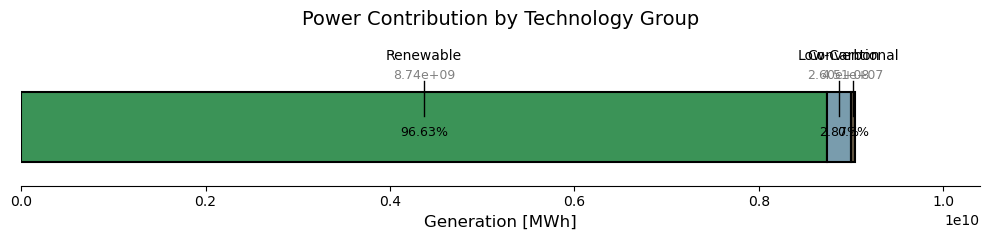

Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 


In [402]:
network_list_summary(CCUS_minimums_bev_30_network_list)

### BEV 90%

In [480]:
CCUS_minimums_bev_90_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/CCUS Scenarios/CCUS minimum all years/CCUS minimum, bev_90%/networks/base_s_39___2020.nc')
CCUS_minimums_bev_90_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/CCUS Scenarios/CCUS minimum all years/CCUS minimum, bev_90%/networks/base_s_39___2030.nc')
CCUS_minimums_bev_90_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/CCUS Scenarios/CCUS minimum all years/CCUS minimum, bev_90%/networks/base_s_39___2040.nc')
CCUS_minimums_bev_90_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/CCUS Scenarios/CCUS minimum all years/CCUS minimum, bev_90%/networks/base_s_39___2050.nc')


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [481]:
CCUS_minimums_bev_90_network_list = [CCUS_minimums_bev_90_2020, CCUS_minimums_bev_90_2030, CCUS_minimums_bev_90_2040,CCUS_minimums_bev_90_2050 ]

In [498]:
CCUS_minimums_bev_90_2030.stores[CCUS_minimums_bev_90_2030.stores.carrier == 'EV battery'].e_nom.sum()

3942057.1083456823

In [499]:
#comparison of BEV availability 
EV_store_size = pd.DataFrame()
EV_store_size.index = [ 2030, 2040, 2050]
EV_store_size['BEV_30%'] = [CCUS_minimums_bev_30_network_list[1].stores[CCUS_minimums_bev_30_network_list[1].stores.carrier == 'EV battery'].e_nom.sum(), CCUS_minimums_bev_30_network_list[2].stores[CCUS_minimums_bev_30_network_list[2].stores.carrier == 'EV battery'].e_nom.sum(), CCUS_minimums_bev_30_network_list[3].stores[CCUS_minimums_bev_30_network_list[3].stores.carrier == 'EV battery'].e_nom.sum()]
EV_store_size['BEV_90%'] = [CCUS_minimums_bev_90_network_list[1].stores[CCUS_minimums_bev_90_network_list[1].stores.carrier == 'EV battery'].e_nom.sum(), CCUS_minimums_bev_90_network_list[2].stores[CCUS_minimums_bev_90_network_list[2].stores.carrier == 'EV battery'].e_nom.sum(), CCUS_minimums_bev_90_network_list[3].stores[CCUS_minimums_bev_90_network_list[3].stores.carrier == 'EV battery'].e_nom.sum()]
EV_store_size

BEV_30%       BEV_90%
2030  1.314019e+06  3.942057e+06
2040  3.066044e+06  9.198133e+06
2050  4.380063e+06  1.314019e+07

In [520]:
#hydrogen limits test 
hydrogen_electrolysis_limit_test(CCUS_minimums_bev_90_2020, 2020)
hydrogen_electrolysis_limit_test(CCUS_minimums_bev_90_2030, 2030)
hydrogen_electrolysis_limit_test(CCUS_minimums_bev_90_2040, 2040)
hydrogen_electrolysis_limit_test(CCUS_minimums_bev_90_2050, 2050)
#Carbon tests
carbon_sequestration_limit_test(CCUS_minimums_bev_90_2020, 2020)
carbon_sequestration_limit_test(CCUS_minimums_bev_90_2030, 2030)
carbon_sequestration_limit_test(CCUS_minimums_bev_90_2040, 2040)
carbon_sequestration_limit_test(CCUS_minimums_bev_90_2050, 2050)
#transmission limit 
transmission_limit_test(CCUS_minimums_bev_90_2020, 2020)
transmission_limit_test(CCUS_minimums_bev_90_2030, 2020)
transmission_limit_test(CCUS_minimums_bev_90_2040, 2020)
transmission_limit_test(CCUS_minimums_bev_90_2050, 2020)
#this is appropriate for the BAU scenario 

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Does the Carbon sequestration limit exist?
Yes

network objective
2020 : 5.37e+11 
2030 : 4.53e+11 
2040 : 6.54e+11 
2050 : 6.57e+10 

system makeup -- all sectors
2020


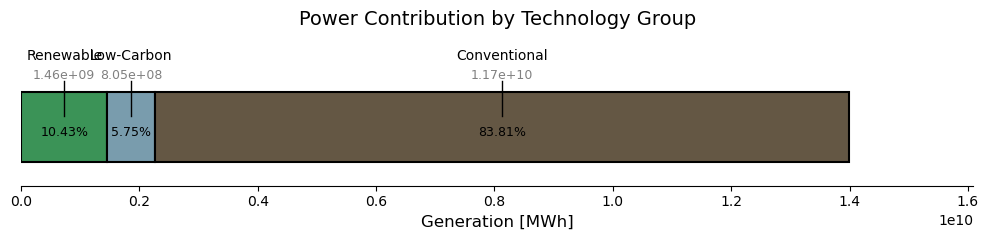

2030


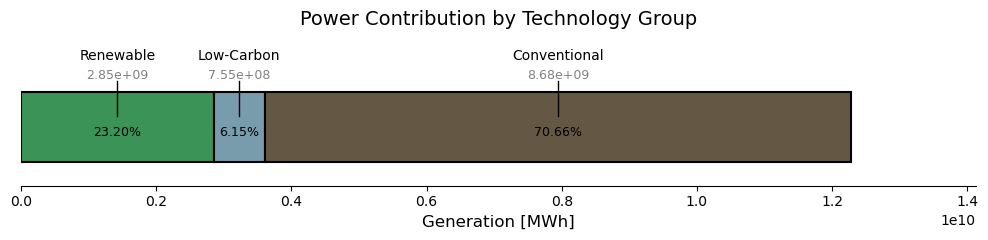

2040


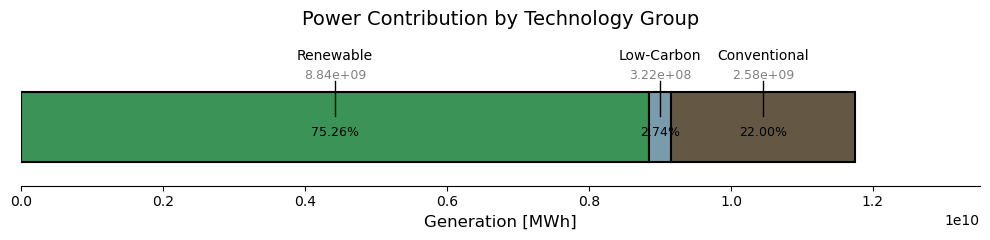

2050


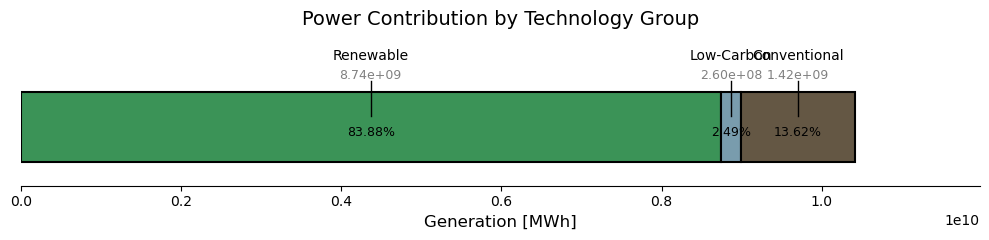

system makeup -- power sector
2020


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



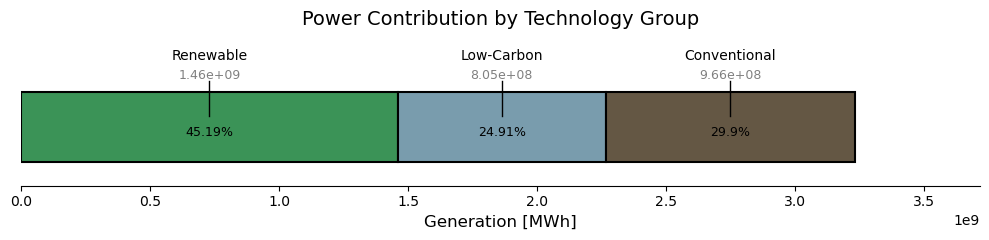

2030


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



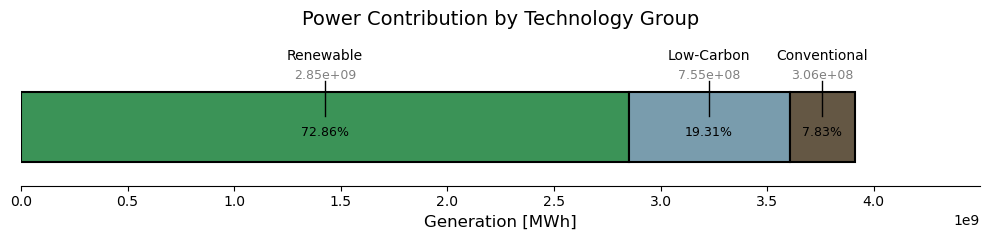

2040


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



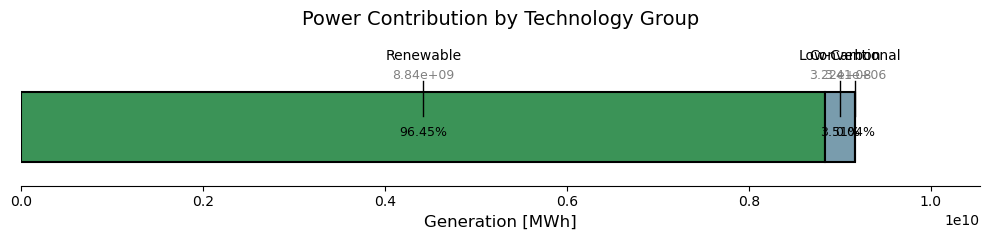

2050


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



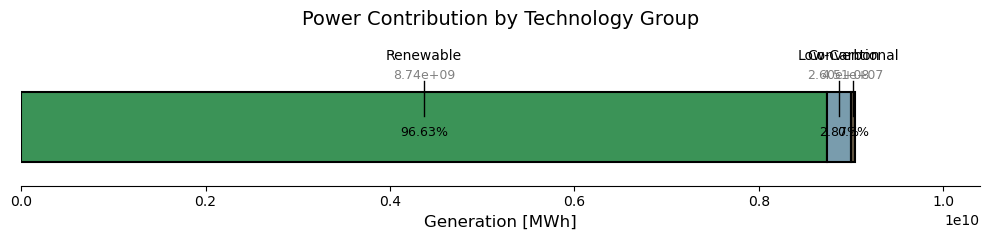

Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 


In [502]:
network_list_summary(CCUS_minimums_bev_30_network_list)

In [893]:
#cost 
cost_dataframe = pd.DataFrame()
cost_dataframe.index = [2020, 2030, 2040, 2050]
cost_dataframe['BAU - no flex'] = [n.objective for n in BAU_no_flex_network_list]
cost_dataframe['CCUS minimum'] = [n.objective for n in CCUS_minimum_no_flex]
cost_dataframe['CCUS minimum - BEV 30%'] = [n.objective for n in CCUS_minimums_bev_30_network_list]
cost_dataframe['CCUS minimum - BEV 90%'] = [n.objective for n in CCUS_minimums_bev_90_network_list]


cost_dataframe.style.background_gradient(cmap = plt.cm.Blues, axis = 1).format("{:.5e}")

In [894]:
#how does the generation built differ between BAU and CCUS minimums?
generation_dataframe = pd.DataFrame()
generation_dataframe['BAU - no flex : wind'] = [renewables_optimal_capacity(s).loc[['Offshore Wind (AC)', 'Offshore Wind (DC)', 'Offshore Wind (Floating)', 'Onshore Wind']].sum() for s in BAU_no_flex_network_list ]
generation_dataframe['CCUS min - no flex: wind'] = [renewables_optimal_capacity(s).loc[['Offshore Wind (AC)', 'Offshore Wind (DC)', 'Offshore Wind (Floating)', 'Onshore Wind']].sum() for s in CCUS_minimum_no_flex ]
generation_dataframe['CCUS min - bev 30%: wind'] = [renewables_optimal_capacity(s).loc[['Offshore Wind (AC)', 'Offshore Wind (DC)', 'Offshore Wind (Floating)', 'Onshore Wind']].sum() for s in CCUS_minimums_bev_30_network_list ]
generation_dataframe['CCUS min - bev 90%: wind'] = [renewables_optimal_capacity(s).loc[['Offshore Wind (AC)', 'Offshore Wind (DC)', 'Offshore Wind (Floating)', 'Onshore Wind']].sum() for s in CCUS_minimums_bev_90_network_list ]

generation_dataframe['BAU - no flex : solar'] = [renewables_optimal_capacity(s).loc[['Solar', 'solar rooftop', 'solar-hsat']].sum() for s in BAU_no_flex_network_list ]
generation_dataframe['CCUS min - no flex: solar'] = [renewables_optimal_capacity(s).loc[['Solar', 'solar rooftop', 'solar-hsat']].sum() for s in CCUS_minimum_no_flex ]
generation_dataframe['CCUS min - bev 30%: solar'] = [renewables_optimal_capacity(s).loc[['Solar', 'solar rooftop', 'solar-hsat']].sum() for s in CCUS_minimums_bev_30_network_list ]
generation_dataframe['CCUS min - bev 90%: solar'] = [renewables_optimal_capacity(s).loc[['Solar', 'solar rooftop', 'solar-hsat']].sum() for s in CCUS_minimums_bev_90_network_list ]


generation_dataframe.style.background_gradient(cmap = plt.cm.Blues, axis = 1).format("{:.3e}")


### Additional heat low 

In [511]:
CCUS_minimum_low_level_heat_flex_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/CCUS Scenarios/CCUS minimum all years/additional_heat_flex_low_level_25.25mhomes/networks/base_s_39___2020.nc')
CCUS_minimum_low_level_heat_flex_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/CCUS Scenarios/CCUS minimum all years/additional_heat_flex_low_level_25.25mhomes/networks/base_s_39___2030.nc')
CCUS_minimum_low_level_heat_flex_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/CCUS Scenarios/CCUS minimum all years/additional_heat_flex_low_level_25.25mhomes/networks/base_s_39___2040.nc')
CCUS_minimum_low_level_heat_flex_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/CCUS Scenarios/CCUS minimum all years/additional_heat_flex_low_level_25.25mhomes/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [512]:
CCUS_minimum_low_level_heat_flex_network_list = [CCUS_minimum_low_level_heat_flex_2020, CCUS_minimum_low_level_heat_flex_2030, CCUS_minimum_low_level_heat_flex_2040, CCUS_minimum_low_level_heat_flex_2050]


In [ ]:
def add_heat_store_capacity(network):
    return (network.stores[network.stores.index.str.contains('storage', case = False)].e_nom.sum())

[add_heat_store_capacity(n) for n in CCUS_minimum_low_level_heat_flex_network_list]


[23634000.0, 23634000.0, 23634000.0, 23634000.0]

In [521]:
#hydrogen limits test 
hydrogen_electrolysis_limit_test(CCUS_minimum_low_level_heat_flex_2020, 2020)
hydrogen_electrolysis_limit_test(CCUS_minimum_low_level_heat_flex_2030, 2030)
hydrogen_electrolysis_limit_test(CCUS_minimum_low_level_heat_flex_2040, 2040)
hydrogen_electrolysis_limit_test(CCUS_minimum_low_level_heat_flex_2050, 2050)
#Carbon tests
carbon_sequestration_limit_test(CCUS_minimum_low_level_heat_flex_2020, 2020)
carbon_sequestration_limit_test(CCUS_minimum_low_level_heat_flex_2030, 2030)
carbon_sequestration_limit_test(CCUS_minimum_low_level_heat_flex_2040, 2040)
carbon_sequestration_limit_test(CCUS_minimum_low_level_heat_flex_2050, 2050)
#transmission limit 
transmission_limit_test(CCUS_minimum_low_level_heat_flex_2020, 2020)
transmission_limit_test(CCUS_minimum_low_level_heat_flex_2030, 2020)
transmission_limit_test(CCUS_minimum_low_level_heat_flex_2040, 2020)
transmission_limit_test(CCUS_minimum_low_level_heat_flex_2050, 2020)
#this is appropriate for the BAU scenario 

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Does the Carbon sequestration limit exist?
Yes

network objective
2020 : 5.35e+11 
2030 : 4.58e+11 
2040 : 6.60e+11 
2050 : 6.79e+10 

system makeup -- all sectors
2020


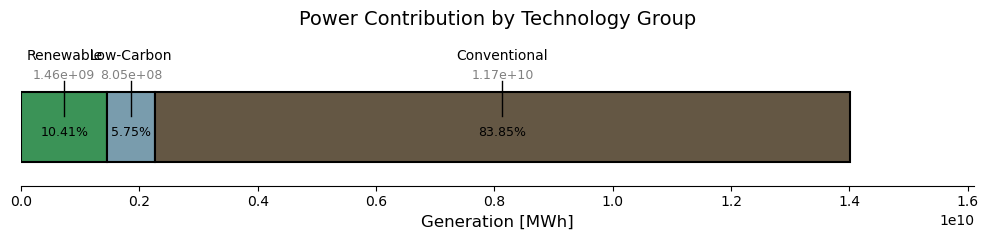

2030


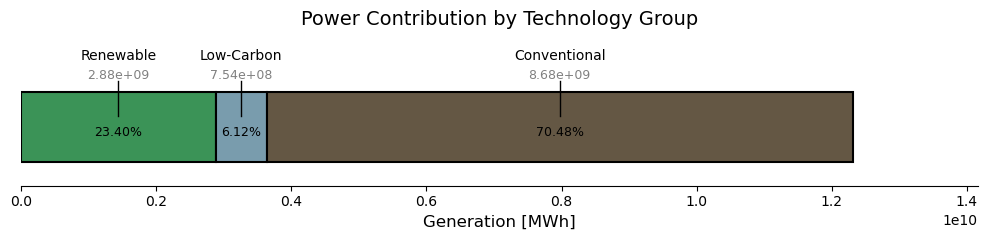

2040


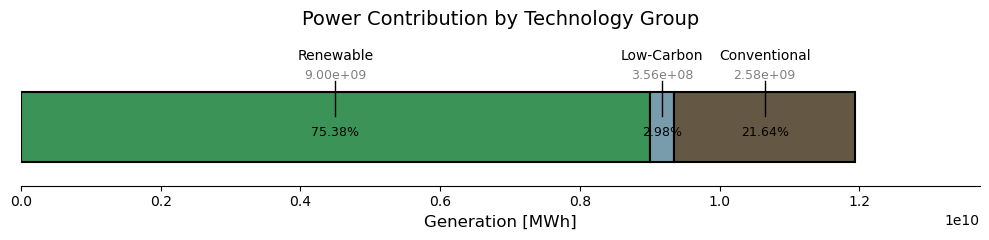

2050


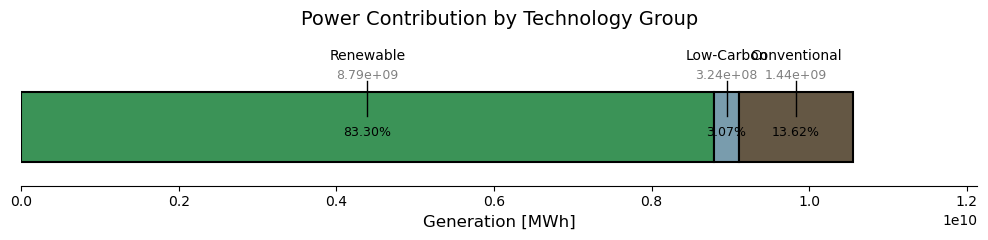

system makeup -- power sector
2020


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



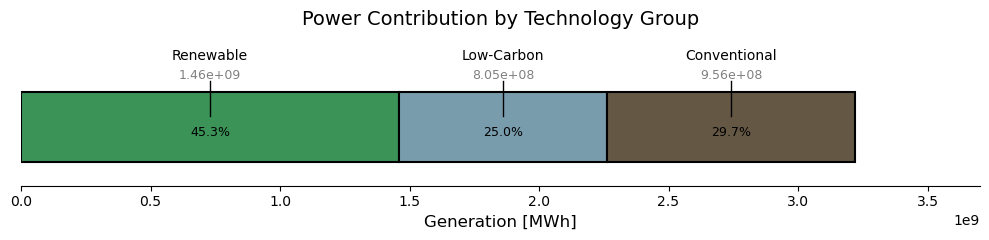

2030


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



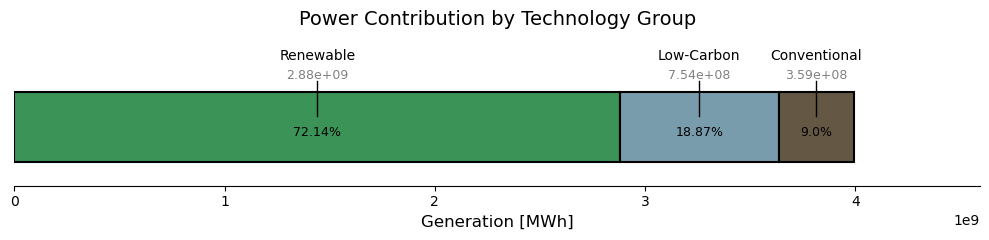

2040


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



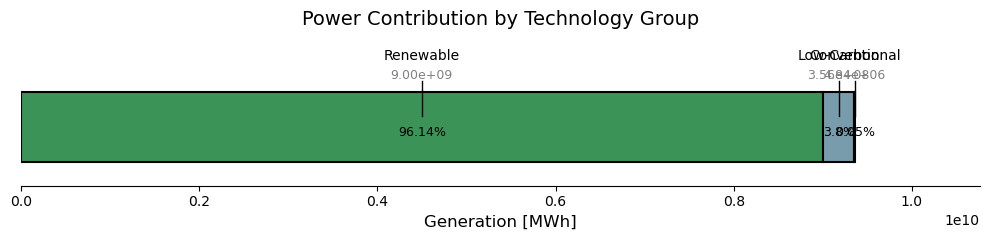

2050


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



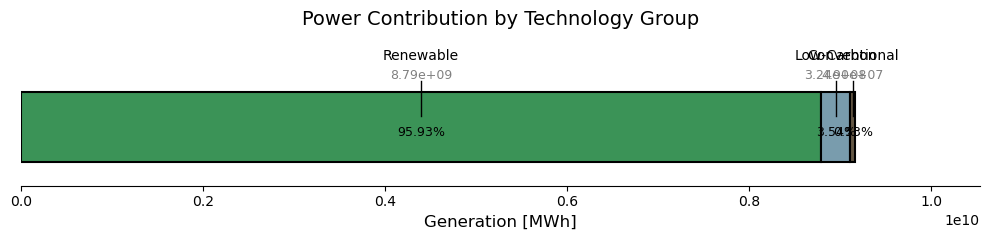

Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 


In [522]:
network_list_summary(CCUS_minimum_low_level_heat_flex_network_list)

In [ ]:
#how does additional heat low level compare to no flex BAU regarding the metric we're interested in? 
#cost 
cost_dataframe = pd.DataFrame()
cost_dataframe.index = [2020, 2030, 2040, 2050]
cost_dataframe['BAU - no flex'] = [n.objective for n in BAU_no_flex_network_list]
cost_dataframe['CCUS minimum'] = [n.objective for n in CCUS_minimum_no_flex]
cost_dataframe['CCUS minimum - heat_flex_low_level'] = [n.objective for n in CCUS_minimum_low_level_heat_flex_network_list]
cost_dataframe.style.background_gradient(cmap=plt.cm.Blues).format("{:.5e}")

### Med-level heat flex

In [538]:
CCUS_minimum_low_level_heat_flex_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/CCUS Scenarios/CCUS minimum all years/additional_heat_flex_med_level_50.50m_homes/networks/base_s_39___2020.nc')
CCUS_minimum_low_level_heat_flex_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/CCUS Scenarios/CCUS minimum all years/additional_heat_flex_med_level_50.50m_homes/networks/base_s_39___2030.nc')
CCUS_minimum_low_level_heat_flex_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/CCUS Scenarios/CCUS minimum all years/additional_heat_flex_med_level_50.50m_homes/networks/base_s_39___2040.nc')
CCUS_minimum_low_level_heat_flex_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/CCUS Scenarios/CCUS minimum all years/additional_heat_flex_med_level_50.50m_homes/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [539]:
CCUS_minimum_med_level_heat_flex_network_list = [CCUS_minimum_low_level_heat_flex_2020, CCUS_minimum_low_level_heat_flex_2030, CCUS_minimum_low_level_heat_flex_2040, CCUS_minimum_low_level_heat_flex_2050]

In [540]:
#additional heating storage 
heat_capacity = pd.DataFrame()
heat_capacity.index = [2020, 2030, 2040, 2050]
heat_capacity['low level additions'] = [add_heat_store_capacity(n) for n in CCUS_minimum_low_level_heat_flex_network_list]
heat_capacity['med level addditions'] = [add_heat_store_capacity(n) for n in CCUS_minimum_med_level_heat_flex_network_list]
heat_capacity


low level additions  med level addditions
2020           23634000.0            47268000.0
2030           23634000.0            47268000.0
2040           23634000.0            47268000.0
2050           23634000.0            47268000.0

In [542]:
#how does additional heat low level compare to no flex BAU regarding the metric we're interested in? 
#cost 
cost_dataframe = pd.DataFrame()
cost_dataframe.index = [2020, 2030, 2040, 2050]
cost_dataframe['BAU - no flex'] = [n.objective for n in BAU_no_flex_network_list]
cost_dataframe['CCUS minimum'] = [n.objective for n in CCUS_minimum_no_flex]
cost_dataframe['CCUS minimum - heat_flex_low_level'] = [n.objective for n in CCUS_minimum_low_level_heat_flex_network_list]
cost_dataframe['CCUS minimum - heat_flex_med_level'] = [n.objective for n in CCUS_minimum_med_level_heat_flex_network_list]

cost_dataframe.style.background_gradient(cmap=plt.cm.Blues, axis = 1).format("{:.5e}")

### Comparison of CCUS minimums flex

In [505]:
#how does BEV_30% and bev_90% compare to no flex regarding the metric we're interested in? 
#cost 
cost_dataframe = pd.DataFrame()
cost_dataframe.index = [2020, 2030, 2040, 2050]
cost_dataframe['BAU - no flex'] = [n.objective for n in BAU_no_flex_network_list]
cost_dataframe['CCUS minimum'] = [n.objective for n in CCUS_minimum_no_flex]
cost_dataframe['CCUS minimum: BEV 30%'] = [n.objective for n in CCUS_minimums_bev_30_network_list]
cost_dataframe['CCUS minimum: BEV 90%'] = [n.objective for n in CCUS_minimums_bev_90_network_list]

cmap_choice = plt.cm.Blues
cost_dataframe.style.background_gradient(cmap=cmap_choice, axis =1).format("{:.5e}")

In [ ]:

#curtailment Fraction 
#(available renewable energy - used renewable energ) / available 
curtailment_dataframe = pd.DataFrame()
curtailment_dataframe.index = [2020, 2030, 2040, 2050]
curtailment_dataframe['BAU - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['CCUS min : wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in CCUS_minimum_no_flex ]
curtailment_dataframe['CCUS min BEV flex 30%: wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in CCUS_minimums_bev_30_network_list ]
curtailment_dataframe['CCUS min BEV flex 90%: wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in CCUS_minimums_bev_90_network_list ]

curtailment_dataframe['BAU - no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'rural solar thermal', 'solar rooftop', 'solar-hsat']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['CCUS min : solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'rural solar thermal', 'solar rooftop', 'solar-hsat']].mean() for s in CCUS_minimum_no_flex ]
curtailment_dataframe['CCUS min BEV flex 30%: solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'rural solar thermal', 'solar rooftop', 'solar-hsat']].mean() for s in CCUS_minimums_bev_30_network_list ]
curtailment_dataframe['CCUS min BEV flex 90%: solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'rural solar thermal', 'solar rooftop', 'solar-hsat']].mean() for s in CCUS_minimums_bev_90_network_list ]

curtailment_dataframe.style.background_gradient(cmap=cmap_choice, axis = 1)

In [ ]:

#Absolute Curtailment in MWh  
curtailment_dataframe = pd.DataFrame()
curtailment_dataframe.index = [2020, 2030, 2040, 2050]
curtailment_dataframe['BAU - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['BAU - BEV 30% : wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in BAU_bev_30_network_list ]
curtailment_dataframe['CCUS min : wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in CCUS_minimum_no_flex ]
curtailment_dataframe['CCUS min BEV flex 30%: wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in CCUS_minimums_bev_30_network_list ]
curtailment_dataframe['CCUS min BEV flex 90%: wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in CCUS_minimums_bev_90_network_list ]

#curtailment_dataframe2 = pd.DataFrame()
#curtailment_dataframe2.index = [2020, 2030, 2040, 2050]

#curtailment_dataframe2['BAU - no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar', 'rural solar thermal', 'solar rooftop', 'solar-hsat']].mean() for s in BAU_no_flex_network_list ]
#curtailment_dataframe2['CCUS min : solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar', 'rural solar thermal', 'solar rooftop', 'solar-hsat']].mean() for s in CCUS_minimum_no_flex ]
#curtailment_dataframe2['CCUS min BEV flex 30%: solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar', 'rural solar thermal', 'solar rooftop', 'solar-hsat']].mean() for s in CCUS_minimums_bev_30_network_list ]
#curtailment_dataframe2['CCUS min BEV flex 90%: solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar', 'rural solar thermal', 'solar rooftop', 'solar-hsat']].mean() for s in CCUS_minimums_bev_90_network_list ]


import matplotlib as mpl
cmap_choice = plt.cm.Reds
curtailment_dataframe.style.background_gradient(cmap=cmap_choice, axis = 1).format("{:.5e}")  # try "coolwarm", "plasma", etc.


In [510]:
curtailment_dataframe2.style.background_gradient(cmap=cmap_choice, axis = 1).format("{:.5e}")  # try "coolwarm", "plasma", etc.


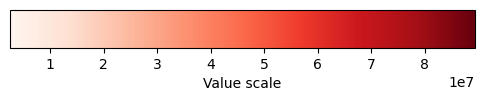

light red: low value, dark red: high value


In [479]:

# ---- Make a legend (colorbar) ----

norm = mpl.colors.Normalize(vmin=curtailment_dataframe.values.min(), vmax=curtailment_dataframe.values.max())
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

# Create colorbar
cb = mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.Reds, norm=norm, orientation='horizontal')
cb.set_label("Value scale")

plt.show()
print('light red: low value, dark red: high value')

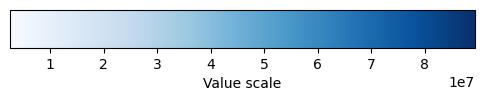

light blue: low, dark blue: high


In [477]:
# ---- Make a legend (colorbar) ----
norm = mpl.colors.Normalize(vmin=curtailment_dataframe.values.min(), vmax=curtailment_dataframe.values.max())
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

# Create colorbar
cb = mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.Blues, norm=norm, orientation='horizontal')
cb.set_label("Value scale")

plt.show()
print('light blue: low, dark blue: high')

## Hydrogen Minimums -- all years 

In [577]:
Hydrogen_minimums_no_flex_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/Hydrogen Scenarios/Hydrogen_minimum_all_years_no_flex/networks/base_s_39___2020.nc')
Hydrogen_minimums_no_flex_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/Hydrogen Scenarios/Hydrogen_minimum_all_years_no_flex/networks/base_s_39___2030.nc')
Hydrogen_minimums_no_flex_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/Hydrogen Scenarios/Hydrogen_minimum_all_years_no_flex/networks/base_s_39___2040.nc')
Hydrogen_minimums_no_flex_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/Hydrogen Scenarios/Hydrogen_minimum_all_years_no_flex/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [578]:
Hydrogen_minimums_no_flex_network_list = [Hydrogen_minimums_no_flex_2020, Hydrogen_minimums_no_flex_2030, Hydrogen_minimums_no_flex_2040, Hydrogen_minimums_no_flex_2050  ]


In [583]:
Hydrogen_tech_list = ['H2 Electrolysis', 'H2 Fuel Cell', 'H2 pipeline', 'H2 pipeline retrofitted','SMR', 'SMR CC']
optimal_capacity = {}
years = [2020, 2030, 2040, 2050]
for i, n in enumerate(Hydrogen_minimums_no_flex_network_list):
    optimal_capacity_year = {}
    for tech in Hydrogen_tech_list:
        stat_tuple = ('Link', f'{tech}')
        if stat_tuple in n.statistics().index:
            optimal_capacity_tech = n.statistics()['Optimal Capacity'].loc[stat_tuple]
            optimal_capacity_tech = optimal_capacity_tech / 1000 #turning MW into GW
            optimal_capacity_year[tech] = optimal_capacity_tech
        else:
            optimal_capacity_year[tech] = 0
    optimal_capacity[str(years[i])] = optimal_capacity_year


In [586]:
optimal_capacity['2050']

{'H2 Electrolysis': 322.03715438999996,
 'H2 Fuel Cell': 1.203e-05,
 'H2 pipeline': 25.465112079999997,
 'H2 pipeline retrofitted': 22.927375599999998,
 'SMR': 17.61001397,
 'SMR CC': 1.425e-05}

In [ ]:
#hydrogen limits test  -- this test doesn't work as the above shows that the limit is not the BAU limit
hydrogen_electrolysis_limit_test(Hydrogen_minimums_no_flex_2020, 2020)
hydrogen_electrolysis_limit_test(Hydrogen_minimums_no_flex_2030, 2030)
hydrogen_electrolysis_limit_test(Hydrogen_minimums_no_flex_2040, 2040)
hydrogen_electrolysis_limit_test(Hydrogen_minimums_no_flex_2050, 2050)
#Carbon tests
carbon_sequestration_limit_test(Hydrogen_minimums_no_flex_2020, 2020)
carbon_sequestration_limit_test(Hydrogen_minimums_no_flex_2030, 2030)
carbon_sequestration_limit_test(Hydrogen_minimums_no_flex_2040, 2040)
carbon_sequestration_limit_test(Hydrogen_minimums_no_flex_2050, 2050)
#transmission limit 
transmission_limit_test(Hydrogen_minimums_no_flex_2020, 2020)
transmission_limit_test(Hydrogen_minimums_no_flex_2030, 2020)
transmission_limit_test(Hydrogen_minimums_no_flex_2040, 2020)
transmission_limit_test(Hydrogen_minimums_no_flex_2050, 2020)
#this is appropriate for the BAU scenario 

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does a hydrogen limit exist?
Yes

does the hydrogen limit plus the installed capacity equal the limit in the configuration file?
Yes, constraint working and abided by

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Does the Carbon sequestration limit exist?
Yes

network objective
2020 : 5.38e+11 
2030 : 4.62e+11 
2040 : 5.26e+11 
2050 : 1.29e+11 

system makeup -- all sectors
2020


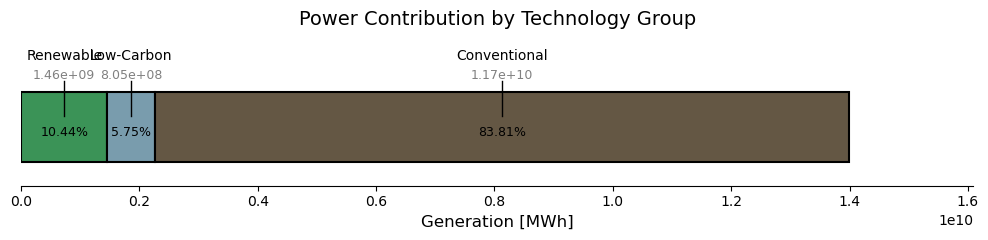

2030


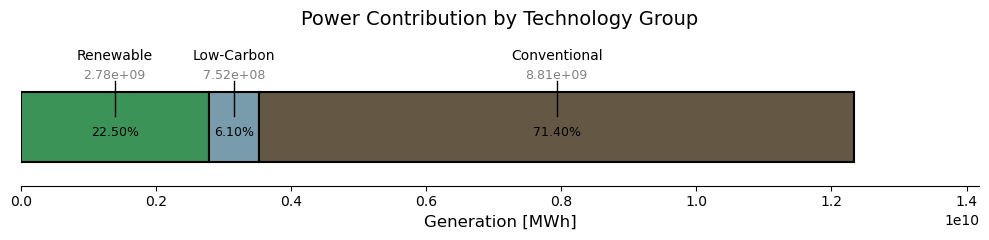

2040


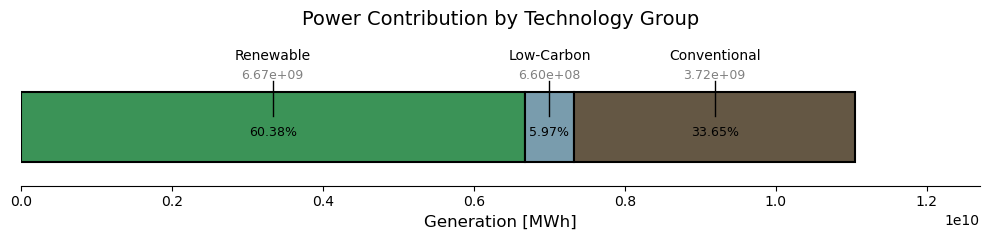

2050


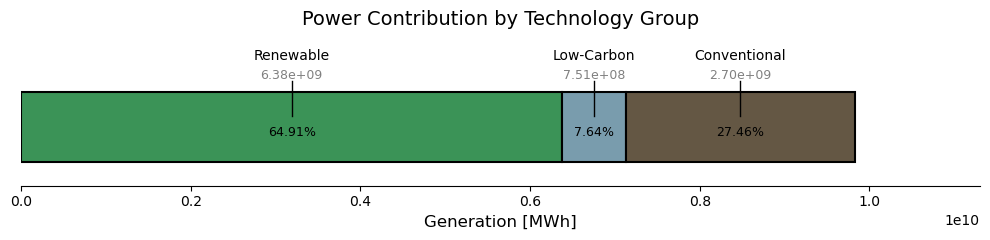

system makeup -- power sector
2020


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



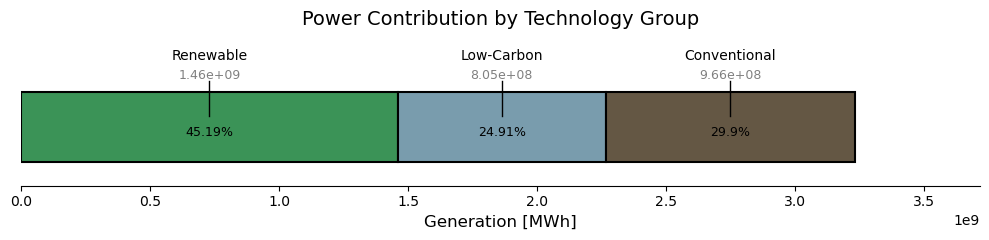

2030


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



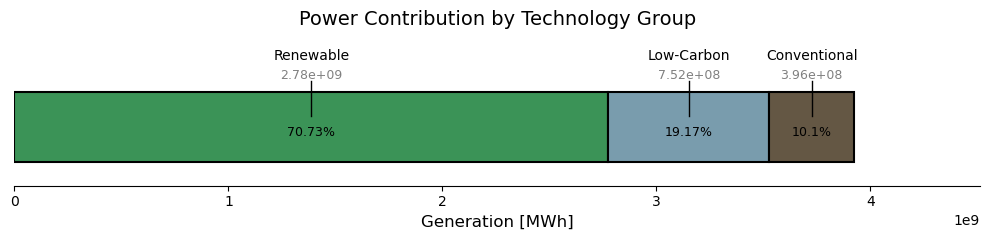

2040


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



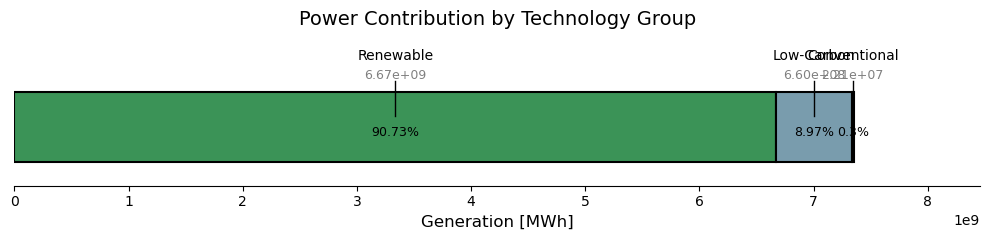

2050


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



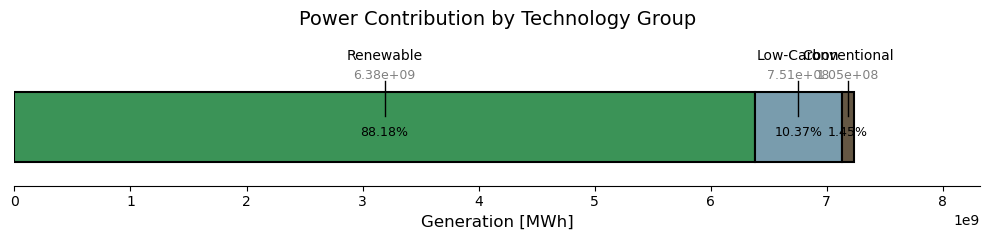

Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 


In [588]:
network_list_summary(Hydrogen_minimums_no_flex_network_list)

Looks like the hydrogen limits are less renewable than before -- less renewables used/builtout? 

In [589]:
#how does additional heat low level compare to no flex BAU regarding the metric we're interested in? 
#cost 
cost_dataframe = pd.DataFrame()
cost_dataframe.index = [2020, 2030, 2040, 2050]
cost_dataframe['BAU - no flex'] = [n.objective for n in BAU_no_flex_network_list]
cost_dataframe['CCUS minimum - no flex'] = [n.objective for n in CCUS_minimum_no_flex]
cost_dataframe['Hydrogen minimum - no flex'] = [n.objective for n in Hydrogen_minimums_no_flex_network_list]

cost_dataframe.style.background_gradient(cmap=plt.cm.Blues, axis = 1).format("{:.5e}")

In [606]:
#renewables buildout by 2050
renewable_buildout = pd.DataFrame()
BAU_no_flex_wind = BAU_no_flex_network_list[3].statistics()['Optimal Capacity'].loc['Generator'].loc[['Offshore Wind (AC)', 'Offshore Wind (DC)', 'Offshore Wind (Floating)', 'Onshore Wind']].sum() #MW
BAU_no_flex_wind

BAU_no_flex_solar = BAU_no_flex_network_list[3].statistics()['Optimal Capacity'].loc['Generator'].loc[['Solar', 'solar rooftop', 'solar-hsat']].sum() #MW
BAU_no_flex_solar

CCUS_min_no_flex_wind = CCUS_minimum_no_flex[3].statistics()['Optimal Capacity'].loc['Generator'].loc[['Offshore Wind (AC)', 'Offshore Wind (DC)', 'Offshore Wind (Floating)', 'Onshore Wind']].sum() #MW
CCUS_min_no_flex_solar = CCUS_minimum_no_flex[3].statistics()['Optimal Capacity'].loc['Generator'].loc[['Solar', 'solar rooftop', 'solar-hsat']].sum() #MW


Hydrogen_minimums_no_flex_wind = Hydrogen_minimums_no_flex_network_list[3].statistics()['Optimal Capacity'].loc['Generator'].loc[['Offshore Wind (AC)', 'Offshore Wind (DC)', 'Offshore Wind (Floating)', 'Onshore Wind']].sum() #MW
Hydrogen_minimums_no_flex_solar = Hydrogen_minimums_no_flex_network_list[3].statistics()['Optimal Capacity'].loc['Generator'].loc[['Solar', 'solar rooftop', 'solar-hsat']].sum() #MW

renewable_buildout.index = ['BAU no flex', 'CCUS min no flex', 'Hydrogen min no flex']
renewable_buildout['Solar Optimal Capacity [MW]'] = [BAU_no_flex_solar, CCUS_min_no_flex_solar, Hydrogen_minimums_no_flex_solar]
renewable_buildout['Wind Optimal Capacity [MW]'] = [BAU_no_flex_wind, CCUS_min_no_flex_wind, Hydrogen_minimums_no_flex_wind]
renewable_buildout

Solar Optimal Capacity [MW]  Wind Optimal Capacity [MW]
BAU no flex                          1.662806e+06                1.023646e+06
CCUS min no flex                     2.341936e+06                1.520901e+06
Hydrogen min no flex                 1.761198e+06                1.011393e+06

In [ ]:
CCUS_min_no_flex_solar/1000  #this is six times the current solar capacity and twice the current EU projections for solar buildout 
CCUS_min_no_flex_wind/1000 #this is five times the current wind capcity and four times the projected 2050 wind capacity

4.155467129836065

In [ ]:
#how does Hydrogen minimums compare to no flex regarding the metric we're interested in? 
#cost 
curtailment_dataframe = pd.DataFrame()
curtailment_dataframe.index = [2020, 2030, 2040, 2050]
curtailment_dataframe['BAU - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['H2 min - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in Hydrogen_minimums_no_flex_network_list ]

curtailment_dataframe2 = pd.DataFrame()
curtailment_dataframe2.index = [2020, 2030, 2040, 2050]

curtailment_dataframe2['BAU - no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar', 'rural solar thermal', 'solar rooftop', 'solar-hsat']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe2['H2 min - no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment in MWh'].loc[['solar', 'rural solar thermal', 'solar rooftop', 'solar-hsat']].mean() for s in Hydrogen_minimums_no_flex_network_list ]


import matplotlib as mpl
cmap_choice = plt.cm.Reds
curtailment_dataframe.style.background_gradient(cmap=cmap_choice, axis = 1).format("{:.5e}")  # try "coolwarm", "plasma", etc.


In [617]:
#how does Hydrogen minimums compare to no flex regarding the metric we're interested in? 
#cost 
curtailment_dataframe = pd.DataFrame()
curtailment_dataframe.index = [2020, 2030, 2040, 2050]
curtailment_dataframe['BAU - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe['H2 min - no flex : wind'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['offwind-ac', 'offwind-dc', 'offwind-float', 'onwind']].mean() for s in Hydrogen_minimums_no_flex_network_list ]

curtailment_dataframe2 = pd.DataFrame()
curtailment_dataframe2.index = [2020, 2030, 2040, 2050]

curtailment_dataframe2['BAU - no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'rural solar thermal', 'solar rooftop', 'solar-hsat']].mean() for s in BAU_no_flex_network_list ]
curtailment_dataframe2['H2 min - no flex : solar'] = [curtailment_dataframe_calculation(s)['Curtailment Fraction (with respect to available power)'].loc[['solar', 'rural solar thermal', 'solar rooftop', 'solar-hsat']].mean() for s in Hydrogen_minimums_no_flex_network_list ]


import matplotlib as mpl
cmap_choice = plt.cm.Reds
curtailment_dataframe.style.background_gradient(cmap=cmap_choice, axis = 1)  # try "coolwarm", "plasma", etc.


In [624]:
Hydrogen_minimums_no_flex_network_list[0].statistics()

Optimal Capacity  \
Generator Offshore Wind (AC)                            32366.66323   
          Offshore Wind (DC)                                0.01340   
          Offshore Wind (Floating)                          0.01466   
          Onshore Wind                                 222987.09988   
          Run of River                                  48341.66702   
...                                                             ...   
Store     oil                                              40.40534   
          residential rural water tanks                     0.18812   
          residential urban decentral water tanks           0.18456   
          uranium                                           0.77304   
          urban central water tanks                    178133.50018   

                                                   Installed Capacity  \
Generator Offshore Wind (AC)                              32366.64900   
          Offshore Wind (DC)                                  0.00000   
          Offshore Wind (Floating)                            0.00000   
          Onshore Wind                                   222987.08000   
          Run of River                                    48341.66702   
...                                                               ...   
Store     oil                                                 0.00000   
          residential rural water tanks                       0.00000   
          residential urban decentral water tanks             0.00000   
          uranium                                             0.00000   
          urban central water tanks                           0.00000   

                                                         Supply    Withdrawal  \
Generator Offshore Wind (AC)                       1.512710e+08  0.000000e+00   
          Offshore Wind (DC)                       4.522317e+01  0.000000e+00   
          Offshore Wind (Floating)                 3.293052e+01  0.000000e+00   
          Onshore Wind                             4.598960e+08  0.000000e+00   
          Run of River                             1.543799e+08  0.000000e+00   
...                                                         ...           ...   
Store     oil                                      1.724037e+02  1.724037e+02   
          residential rural water tanks            4.414990e+00  1.477750e+01   
          residential urban decentral water tanks  4.775580e+00  1.492000e+01   
          uranium                                  7.811000e-02  7.811000e-02   
          urban central water tanks                7.588003e+06  7.641404e+06   

                                                   Energy Balance  \
Generator Offshore Wind (AC)                         1.512710e+08   
          Offshore Wind (DC)                         4.522317e+01   
          Offshore Wind (Floating)                   3.293052e+01   
          Onshore Wind                               4.598960e+08   
          Run of River                               1.543799e+08   
...                                                           ...   
Store     oil                                        0.000000e+00   
          residential rural water tanks             -1.036251e+01   
          residential urban decentral water tanks   -1.014441e+01   
          uranium                                    0.000000e+00   
          urban central water tanks                 -5.340117e+04   

                                                   Transmission  \
Generator Offshore Wind (AC)                                0.0   
          Offshore Wind (DC)                                0.0   
          Offshore Wind (Floating)                          0.0   
          Onshore Wind                                      0.0   
          Run of River                                      0.0   
...                                                         ...   
Store     oil                                     

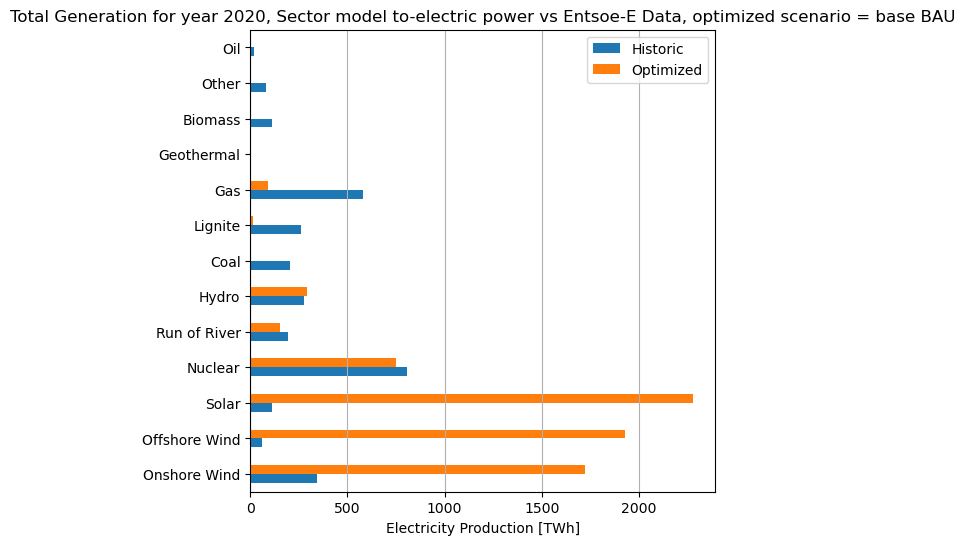

In [603]:
import warnings
# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), pd.Series(electric_supply_from_the_sector_models(Hydrogen_minimums_no_flex_network_list[3])), matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020, Sector model to-electric power vs Entsoe-E Data, optimized scenario = base BAU')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show()  

## Hydrogen Minimums- BEV 30% 

In [662]:
Hydrogen_minimums_bev_30_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/Hydrogen Scenarios/Hydrogen_minimums_bev_30%/networks/base_s_39___2020.nc')
Hydrogen_minimums_bev_30_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/Hydrogen Scenarios/Hydrogen_minimums_bev_30%/networks/base_s_39___2030.nc')
Hydrogen_minimums_bev_30_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/Hydrogen Scenarios/Hydrogen_minimums_bev_30%/networks/base_s_39___2040.nc')
Hydrogen_minimums_bev_30_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/Hydrogen Scenarios/Hydrogen_minimums_bev_30%/networks/base_s_39___2050.nc')


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [665]:
Hydrogen_minimums_bev_30_network_list = [Hydrogen_minimums_bev_30_2020, Hydrogen_minimums_bev_30_2030, Hydrogen_minimums_bev_30_2040, Hydrogen_minimums_bev_30_2050]

In [ ]:

#Carbon tests
carbon_sequestration_limit_test(Hydrogen_minimums_bev_30_2020, 2020)
carbon_sequestration_limit_test(Hydrogen_minimums_bev_30_2030, 2030)
carbon_sequestration_limit_test(Hydrogen_minimums_bev_30_2040, 2040)
carbon_sequestration_limit_test(Hydrogen_minimums_bev_30_2050, 2050)
#transmission limit 
transmission_limit_test(Hydrogen_minimums_bev_30_2020, 2020)
transmission_limit_test(Hydrogen_minimums_bev_30_2030, 2020)
transmission_limit_test(Hydrogen_minimums_bev_30_2040, 2020)
transmission_limit_test(Hydrogen_minimums_bev_30_2050, 2020)
#this is appropriate for the BAU scenario 

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

No transmission limit
No transmission limit
No transmission limit
No transmission limit


network objective
2020 : 5.37e+11 
2030 : 4.56e+11 
2040 : 5.13e+11 
2050 : 1.25e+11 

system makeup -- all sectors
2020


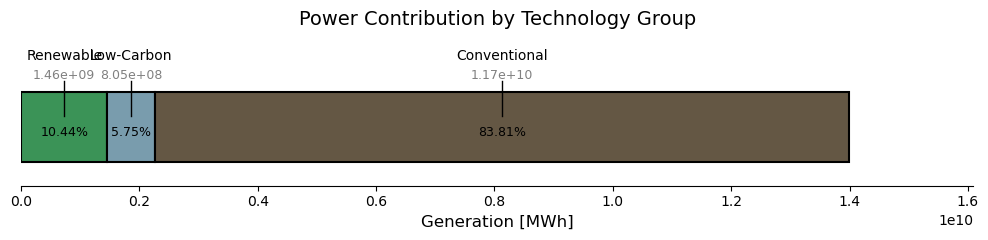

2030


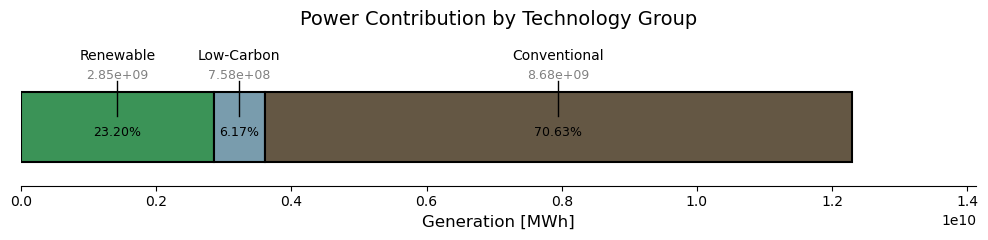

2040


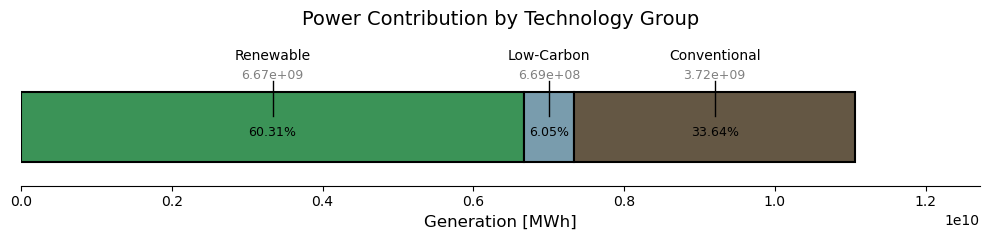

2050


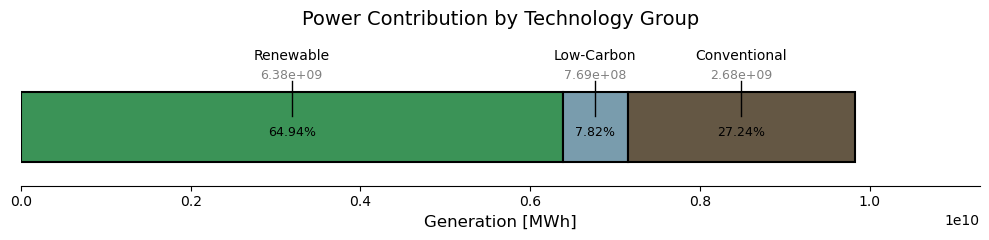

system makeup -- power sector
2020


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



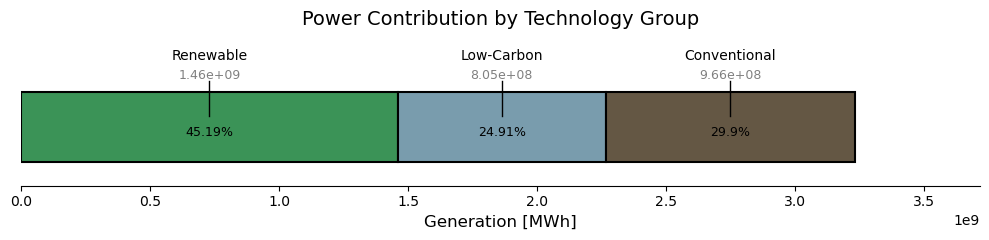

2030


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



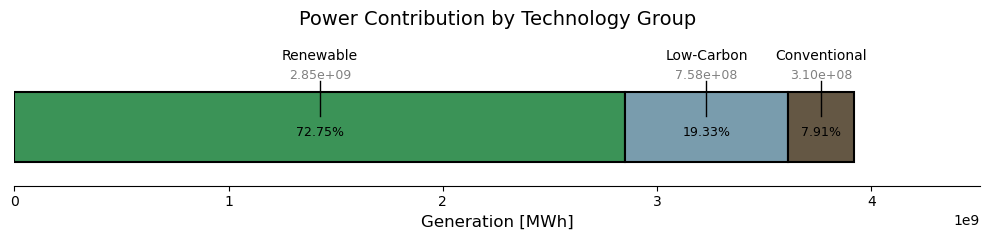

2040


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



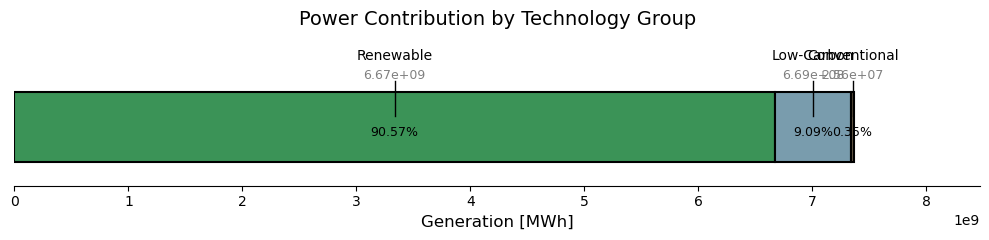

2050


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



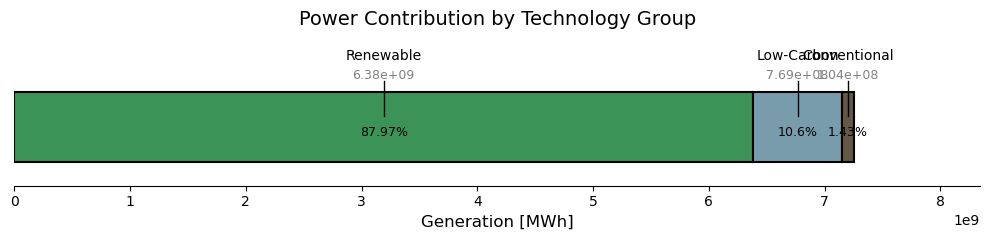

Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 


In [666]:
network_list_summary(Hydrogen_minimums_bev_30_network_list)

In [668]:
#comparison of BEV availability 
EV_store_size2 = pd.DataFrame()
EV_store_size2.index = [ 2030, 2040, 2050]
EV_store_size2['BEV_30%'] = [Hydrogen_minimums_bev_30_network_list[1].stores[Hydrogen_minimums_bev_30_network_list[1].stores.carrier == 'EV battery'].e_nom.sum(), Hydrogen_minimums_bev_30_network_list[2].stores[Hydrogen_minimums_bev_30_network_list[2].stores.carrier == 'EV battery'].e_nom.sum(), Hydrogen_minimums_bev_30_network_list[3].stores[Hydrogen_minimums_bev_30_network_list[3].stores.carrier == 'EV battery'].e_nom.sum()]
#EV_store_size2['BEV_90%'] = [CCUS_minimums_bev_90_network_list[1].stores[CCUS_minimums_bev_90_network_list[1].stores.carrier == 'EV battery'].e_nom.sum(), CCUS_minimums_bev_90_network_list[2].stores[CCUS_minimums_bev_90_network_list[2].stores.carrier == 'EV battery'].e_nom.sum(), CCUS_minimums_bev_90_network_list[3].stores[CCUS_minimums_bev_90_network_list[3].stores.carrier == 'EV battery'].e_nom.sum()]

EV_store_size2

BEV_30%
2030  1.314019e+06
2040  3.066044e+06
2050  4.380063e+06

In [671]:
#how does additional heat low level compare to no flex BAU regarding the metric we're interested in? 
#cost 
cost_dataframe = pd.DataFrame()
cost_dataframe.index = [2020, 2030, 2040, 2050]
cost_dataframe['BAU - no flex'] = [n.objective for n in BAU_no_flex_network_list]
cost_dataframe['CCUS minimum - no flex'] = [n.objective for n in CCUS_minimum_no_flex]
cost_dataframe['Hydrogen minimum - no flex'] = [n.objective for n in Hydrogen_minimums_no_flex_network_list]
cost_dataframe['Hydrogen minimum - BEV 30'] = [n.objective for n in Hydrogen_minimums_bev_30_network_list]

cost_dataframe.style.background_gradient(cmap=plt.cm.Blues, axis = 1).format("{:.5e}")

## Hydrogen Minimums - BEV 90%


In [748]:
Hydrogen_minimums_bev_90_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/Hydrogen Scenarios/Hydrogen_minimums, BEV_90%/networks/base_s_39___2020.nc')
Hydrogen_minimums_bev_90_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/Hydrogen Scenarios/Hydrogen_minimums, BEV_90%/networks/base_s_39___2030.nc')
Hydrogen_minimums_bev_90_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/Hydrogen Scenarios/Hydrogen_minimums, BEV_90%/networks/base_s_39___2040.nc')
Hydrogen_minimums_bev_90_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/Hydrogen Scenarios/Hydrogen_minimums, BEV_90%/networks/base_s_39___2050.nc')


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [749]:
Hydrogen_minimum_bev_90_network_list = [Hydrogen_minimums_bev_90_2020, Hydrogen_minimums_bev_90_2030, Hydrogen_minimums_bev_90_2040, Hydrogen_minimums_bev_90_2050]

In [751]:
#Carbon tests
carbon_sequestration_limit_test(Hydrogen_minimums_bev_90_2020, 2020)
carbon_sequestration_limit_test(Hydrogen_minimums_bev_90_2030, 2030)
carbon_sequestration_limit_test(Hydrogen_minimums_bev_90_2040, 2040)
carbon_sequestration_limit_test(Hydrogen_minimums_bev_90_2050, 2050)

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes

Does the Carbon sequestration limit exist?
Yes
does the carbon sequestration amount is equal to the BAU appropriate configuration value
Yes



network objective
2020 : 5.38e+11 
2030 : 4.52e+11 
2040 : 5.05e+11 
2050 : 1.22e+11 

system makeup -- all sectors
2020


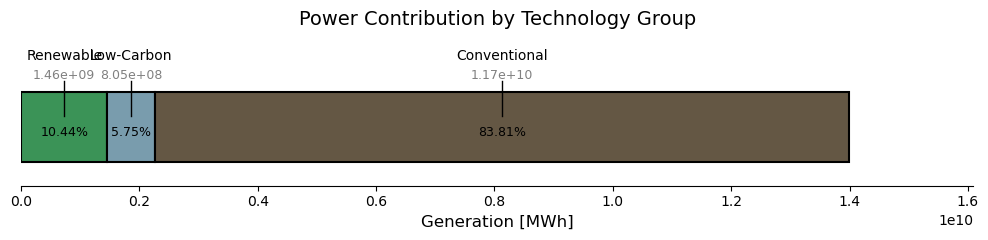

2030


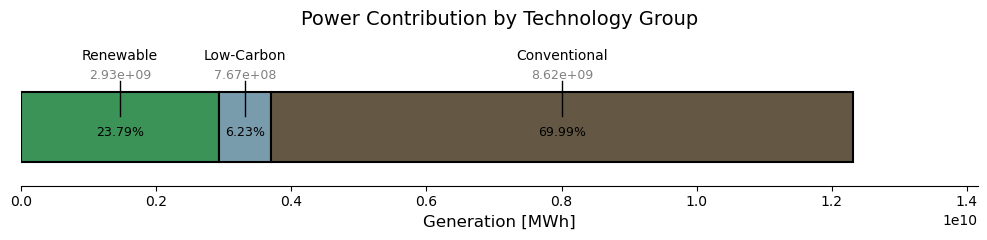

2040


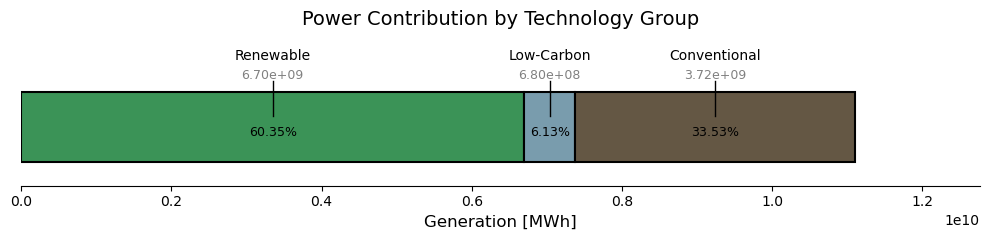

2050


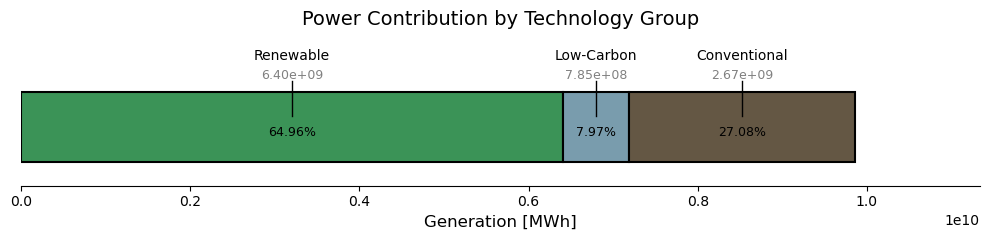

system makeup -- power sector
2020


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



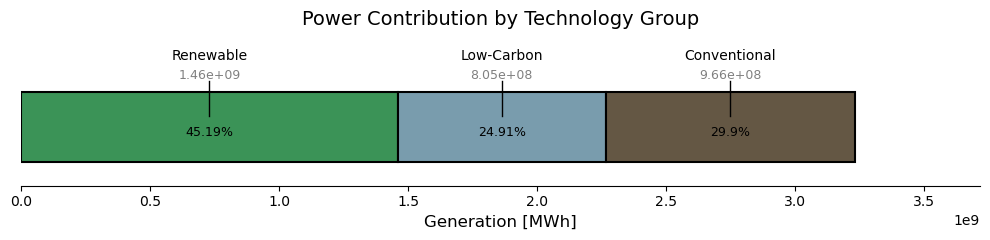

2030


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



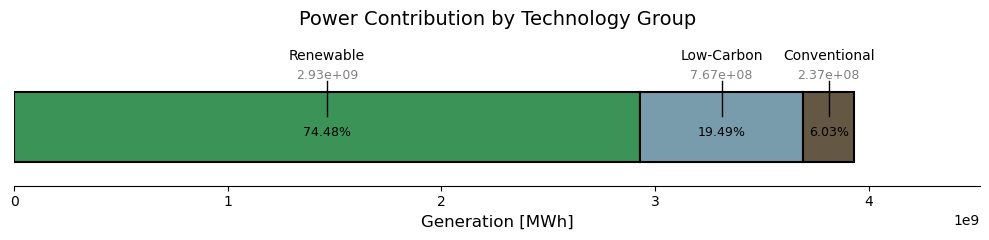

2040


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



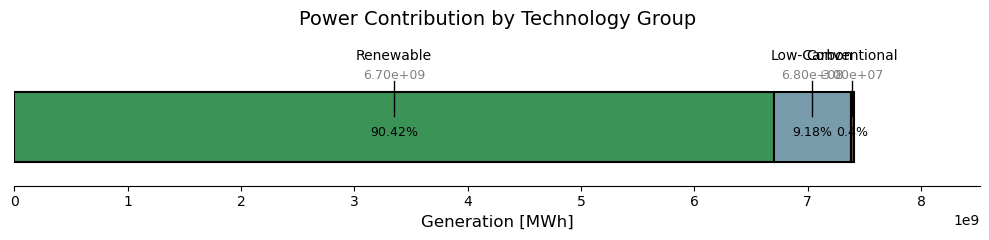

2050


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1431669179.py:109: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



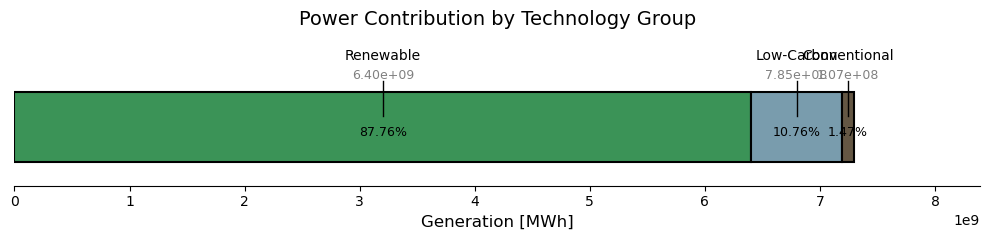

Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 
Carbon constraint exists
Yes, Carbon constraint abided by 


In [752]:
network_list_summary(Hydrogen_minimum_bev_90_network_list)

In [ ]:
#comparison of BEV availability 
EV_store_size2 = pd.DataFrame()
EV_store_size2.index = [ 2030, 2040, 2050]
EV_store_size2['BEV_30%'] = [Hydrogen_minimums_bev_30_network_list[1].stores[Hydrogen_minimums_bev_30_network_list[1].stores.carrier == 'EV battery'].e_nom.sum(), Hydrogen_minimums_bev_30_network_list[2].stores[Hydrogen_minimums_bev_30_network_list[2].stores.carrier == 'EV battery'].e_nom.sum(), Hydrogen_minimums_bev_30_network_list[3].stores[Hydrogen_minimums_bev_30_network_list[3].stores.carrier == 'EV battery'].e_nom.sum()]
EV_store_size2['BEV_90%'] = [Hydrogen_minimum_bev_90_network_list[1].stores[Hydrogen_minimum_bev_90_network_list[1].stores.carrier == 'EV battery'].e_nom.sum(), Hydrogen_minimum_bev_90_network_list[2].stores[Hydrogen_minimum_bev_90_network_list[2].stores.carrier == 'EV battery'].e_nom.sum(), Hydrogen_minimum_bev_90_network_list[3].stores[Hydrogen_minimum_bev_90_network_list[3].stores.carrier == 'EV battery'].e_nom.sum()]
EV_store_size2

BEV_30%       BEV_90%
2030  1.314019e+06  3.942057e+06
2040  3.066044e+06  9.198133e+06
2050  4.380063e+06  1.314019e+07

In [753]:
#how does additional heat low level compare to no flex BAU regarding the metric we're interested in? 
#cost 
cost_dataframe = pd.DataFrame()
cost_dataframe.index = [2020, 2030, 2040, 2050]
cost_dataframe['BAU - no flex'] = [n.objective for n in BAU_no_flex_network_list]
cost_dataframe['CCUS minimum - no flex'] = [n.objective for n in CCUS_minimum_no_flex]
cost_dataframe['Hydrogen minimum - no flex'] = [n.objective for n in Hydrogen_minimums_no_flex_network_list]
cost_dataframe['Hydrogen minimum - BEV 30'] = [n.objective for n in Hydrogen_minimums_bev_30_network_list]
cost_dataframe['Hydrogen minimum - BEV 90'] = [n.objective for n in Hydrogen_minimum_bev_90_network_list]

cost_dataframe.style.background_gradient(cmap=plt.cm.Blues, axis = 1).format("{:.5e}")

# Power Sector Only Investigations

## Graphing Loads, one year

In [ ]:
#this function aids the demand function seperate the different types of demand (by carrier)
def load_dataframe_compiler(network, sector_suffix): #this still returns load dataframes in terms of power dispatch, not in total energy (so MW, not MWH)
    import pandas as pd
    import numpy as np

    # Create a dummy dataframe with load dispatch
    df = pd.DataFrame(network.loads_t.p.T.copy())

    # All loads and their static information 
    df_loads = network.loads.copy()
    carrier_options = df_loads.carrier.unique()

    # Prepare suffix list and remap 'electricity' to empty string
    suffixes = carrier_options.copy()
    if 'electricity' in suffixes:
        suffixes[np.where(suffixes == 'electricity')[0][0]] = ''

    # Check that the given sector_suffix is valid
    if sector_suffix not in suffixes:
        print('network suffix not in suffix list')
        return None

    # Filtering logic
    if sector_suffix == '':
        # Keep only rows where the index suffix after first 5 chars is exactly ''
        filtered_df = df[df.index.str[5:] == ''].copy()
    else:
        # Match any index containing the suffix
        filtered_df = df[df.index.str.contains(sector_suffix, regex=False)].copy()

    return filtered_df



/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/623286469.py:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



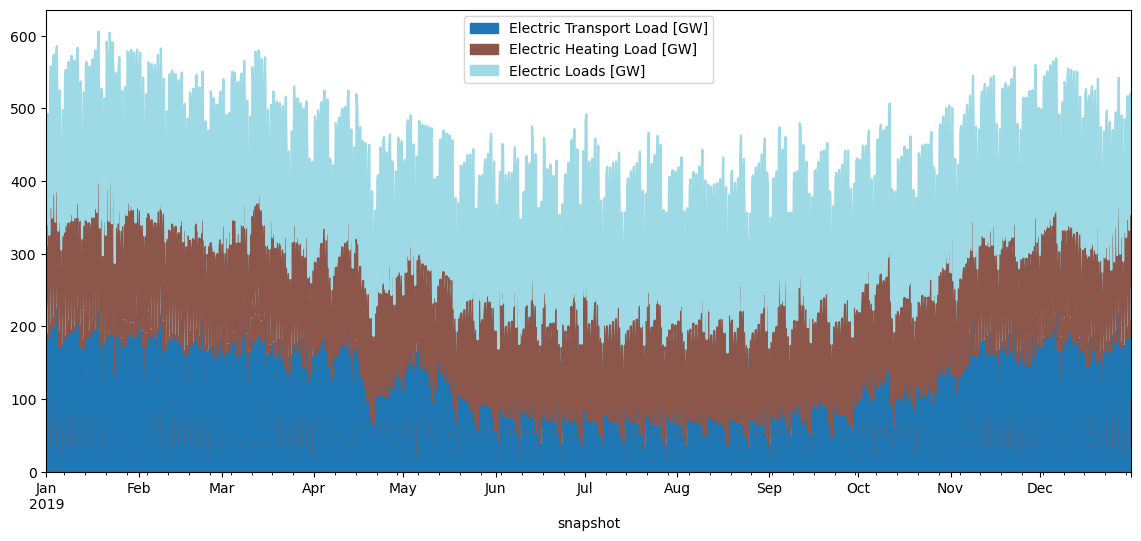

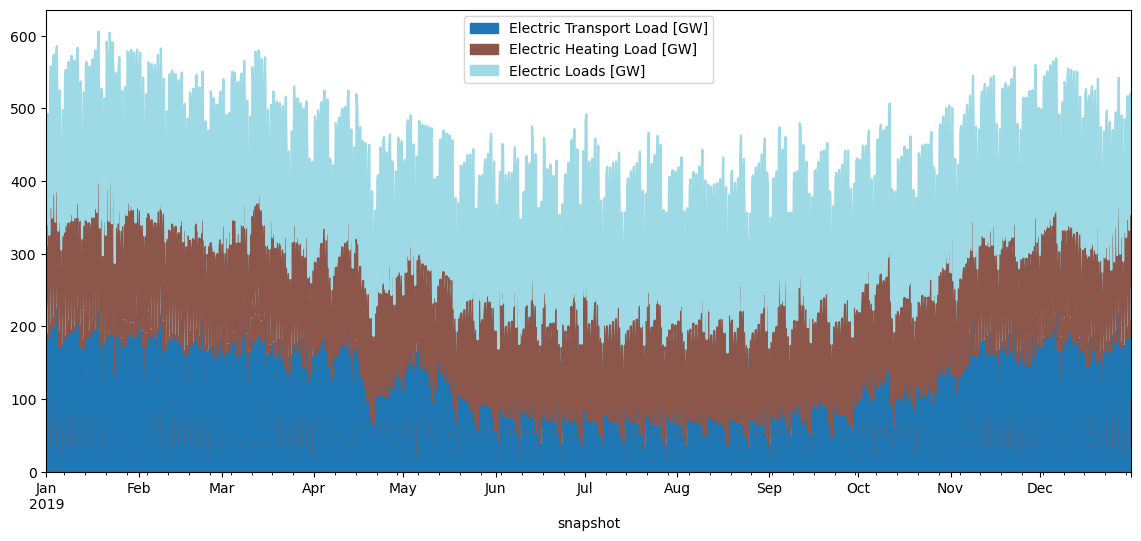

In [946]:
network_choice = BAU_no_flex_2050
def Electric_demand_plot(network):
    fig, ax = plt.subplots(figsize = (14,6))
    electric_loads_in_time = load_dataframe_compiler(network_choice, '').sum().div(1e3) #turning into GW
    transport_loads_in_power_sector = load_dataframe_compiler(network_choice, 'land transport EV').sum().div(1e3) #turning into GW
    #plt.ylabel('GW')
    #electric heating dispatch
    heating_buses = network_choice.buses[network_choice.buses.carrier.isin(['urban central heat', 'urban decentral heat', 'rural heat'])]
    electric_buses = network_choice.buses[network_choice.buses.unit == 'MWh_el']
    heating_to_electric_links = network_choice.links[network_choice.links.bus1.isin(heating_buses.index)][network_choice.links.bus0.isin(electric_buses.index)]
    #heating_to_electric_links.carrier.unique() #carriers include heat pumps and resistive heaters, good. 
    heating_to_electric_link_pull_from_power_sector = network_choice.links_t.p0[heating_to_electric_links.index]
    heating_to_electric_link_pull_from_power_sector = heating_to_electric_link_pull_from_power_sector.T.sum()
    heating_to_electric_link_pull_from_power_sector = heating_to_electric_link_pull_from_power_sector.div(1e3)

    type_dispatch_dataframe = pd.DataFrame()
    type_dispatch_dataframe['Electric Transport Load [GW]'] = transport_loads_in_power_sector
    type_dispatch_dataframe['Electric Heating Load [GW]'] = heating_to_electric_link_pull_from_power_sector
    type_dispatch_dataframe['Electric Loads [GW]'] = electric_loads_in_time
    type_dispatch_dataframe.plot(
            ax = ax,
            kind = 'area',
            stacked = True,
            cmap = 'tab20'
        )
    return fig

Electric_demand_plot(BAU_no_flex_2050)

In [944]:

network = BAU_no_flex_2020.copy()
supply = {}

#renewables 
renewable_carriers = ['solar', 'offwind-dc', 'onwind',
       'offwind-ac', 'offwind-float', 'solar-hsat', 'ror', 'solar rooftop', 'hydro', 'ror', 'PHS']
    #generators 
renewable_generators_by_carrier = network.generators[network.generators.carrier.isin(renewable_carriers)].index
renewable_generators_by_carrier 
renewables_dispatch = network.generators_t.p[renewable_generators_by_carrier]
renewables_dispatch = renewables_dispatch.T
renewables_dispatch=renewables_dispatch.groupby(network.generators.carrier).sum()
renewables_dispatch = renewables_dispatch * network.snapshot_weightings.objective[0] #MW --> MWh 
#renewables_dispatch = renewables_dispatch.sum(axis=1)
#low carbon carriers
low_carbon_carriers = ['nuclear', 'geothermal']
low_carbon_carriers = network.generators[network.generators.carrier.isin(low_carbon_carriers)].index
low_carbon_dispatch = network.generators_t.p[low_carbon_carriers]
low_carbon_dispatch = low_carbon_dispatch * network.snapshot_weightings.objective[0] #MW --> MWh
low_carbon_dispatch = low_carbon_dispatch.T
low_carbon_dispatch = low_carbon_dispatch.groupby(network.generators.carrier).sum()

#conventional carriers = 
conventional_carriers = ['coal', 'lignite', 'CCGT', 'OCGT', 'oil', "urban central solid biomass CHP", "urban central CHP", "urban central solid biomass CHP CC", "urban central CHP CC"] #biomass is technically low carbon, but CHP is given in links. biomass CHP only in urban central
conventional_links = network.links[network.links.carrier.isin(conventional_carriers)].index
conventional_links = network.links_t.p1[conventional_links]#power delivered to the end bus 
conventional_links = conventional_links * network.snapshot_weightings.objective[0] * -1 #MW --> MWh, and multiplied by netgative one because contributing power to those buses
conventional_links = conventional_links.T
conventional_links = conventional_links.groupby(network.links.carrier).sum()
#conventional_links = conventional_links.sum(axis=1)  
  #hydro
  hydro_dispatch = network.storage_units_t.p.T.groupby(network.storage_units.carrier).sum().sum(axis=1) #storage units are just hydro and phs 
  hydro_dispatch = hydro_dispatch * network.snapshot_weightings.objective[0] #MW --> MWh



dispatch_dict = {k: v for s in [renewables_dispatch, low_carbon_dispatch, conventional_links, hydro_dispatch] for k, v in s.items()}
return dispatch_dict 



IndentationError: unexpected indent (1547765042.py, line 32)

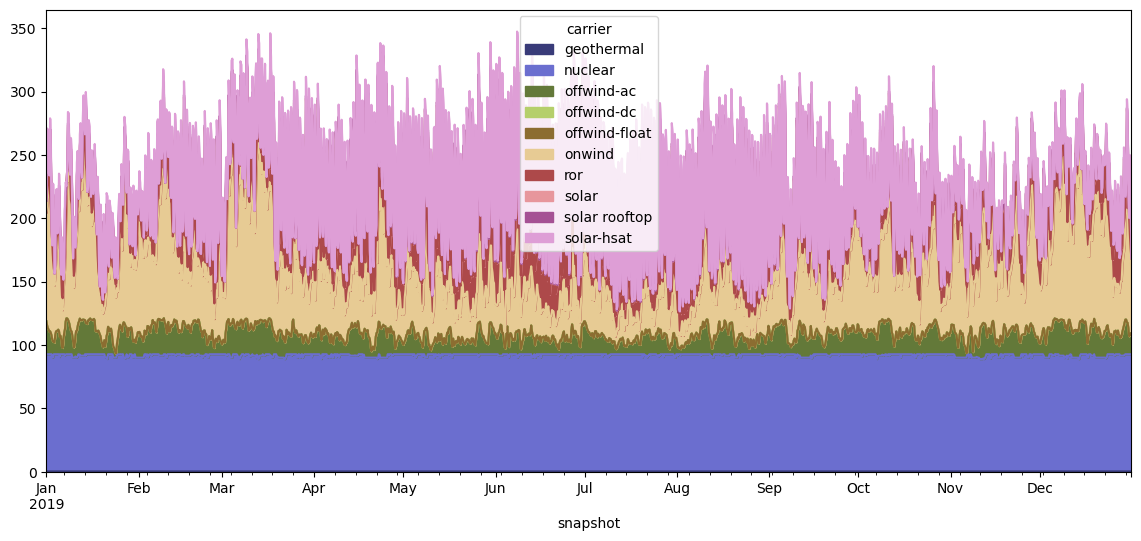

In [ ]:
generation_by_carrier = network.generators_t.p.T.groupby(network.generators.carrier).sum()
fig, ax = plt.subplots(figsize = (14,6))
renewable_carriers = ['solar', 'solar-hsat', 'onwind', 'offwind-ac', 'offwind-dc', 'offwind-float', 'offshore wind', 'hydro', 'ror', 'solar rooftop', 'nuclear', 'geothermal']
renewable_generation = generation_by_carrier[generation_by_carrier.index.isin(renewable_carriers)]
renewable_generation = renewable_generation.div(1e3) #turned MW into Gw
total_dispatch = renewable_generation.T.copy()
total_dispatch.plot(
        ax = ax,
        kind = 'area',
        stacked = True,
        cmap = 'tab20b'
    )
plt.show()

In [ ]:
network.buses.carrier.unique()

array(['AC', 'lignite', 'coal', 'oil', 'oil primary', 'uranium', 'gas',
       'none', 'co2', 'co2 stored', 'co2 sequestered', 'H2', 'battery',
       'land transport oil', 'urban central heat',
       'urban central water tanks', 'biogas', 'solid biomass',
       'unsustainable bioliquids', 'methanol',
       'solid biomass for industry', 'gas for industry',
       'industry methanol', 'shipping oil', 'naphtha for industry',
       'kerosene for aviation', 'process emissions', 'coal for industry',
       'agriculture machinery oil', 'low voltage', 'home battery',
       'rural heat', 'rural water tanks', 'urban decentral heat',
       'urban decentral water tanks'], dtype=object)

<Axes: xlabel='snapshot'>

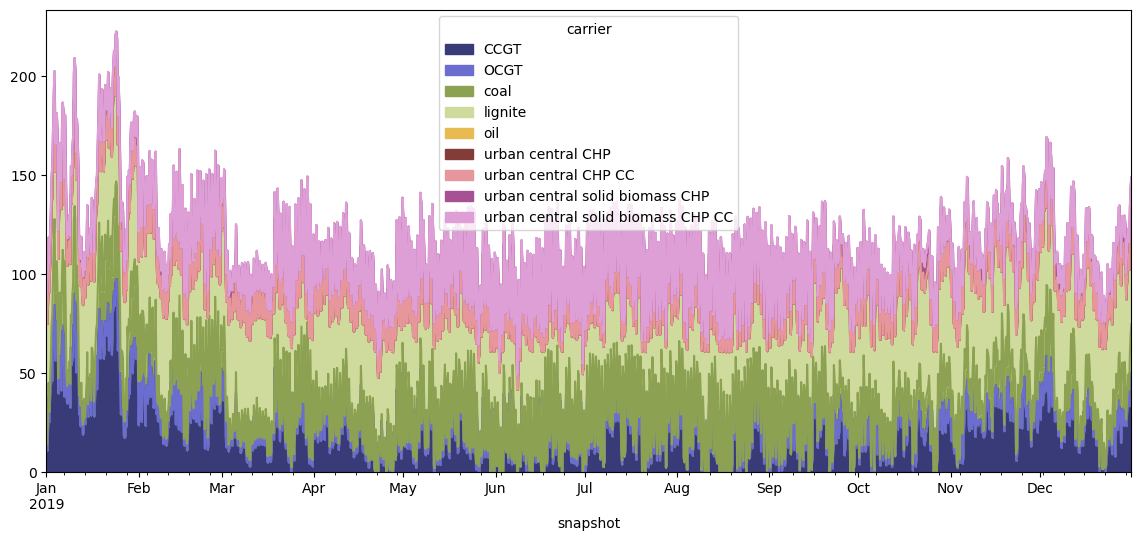

In [ ]:
#conventional links to electric buses (to which electric demand will be connected)
fig, ax = plt.subplots(figsize = (14,6))

network = BAU_no_flex_2020.copy()
#conventional_cariers for buses
conventional_carriers = ['coal', 'lignite', 'CCGT', 'OCGT', 'oil', "urban central solid biomass CHP", "urban central CHP", "urban central solid biomass CHP CC", "urban central CHP CC"] #biomass is technically low carbon, but CHP is given in links. biomass CHP only in urban central

#buses_with_conventional_carriers = network.buses.copy()[network.buses.carrier.isin(conventional_carriers)].index
#conventional_links = network.links[network.links.bus0.isin(buses_with_conventional_carriers)]
#want to separate the conventionals that are going to buses that operate in Mwh_th and buses that operate in MWh_el
#Mwh_el_buses = network.buses[network.buses.unit == 'MWh_el'].index
#conventioanl_links_from_thermal_to_electric = conventional_links[conventional_links.bus1.isin(Mwh_el_buses)]

conventional_links = network.links[network.links.carrier.isin(conventional_carriers)]
#conventional thermal to electric dispatch
mask = conventional_links.index
conventional_to_electric_dispatch_at_end_of_link = ((network.links_t.p1.T.loc[mask]).groupby(network.links.carrier).sum().T)*-1
conventional_to_electric_dispatch_at_end_of_link.div(1e3).plot( #turned from MW to GW
        ax = ax,
        kind = 'area',
        stacked = True,
        cmap = 'tab20b'
    )

array(['DC', 'OCGT', 'lignite', 'coal', 'CCGT', 'H2 Fuel Cell',
       'battery charger', 'battery discharger', 'urban central CHP',
       'urban central CHP CC', 'urban central solid biomass CHP',
       'urban central solid biomass CHP CC',
       'electricity distribution grid', 'home battery charger',
       'home battery discharger', 'nuclear', 'oil'], dtype=object)

In [ ]:
#dispatch across stores, storage units, and generators 
def all_dispatch_plus_load_electric_test(network):
    fig, ax = plt.subplots(figsize = (14,10))
    # generation associations
    generation_by_carrier = network.generators_t.p.T.groupby(network.generators.carrier).sum()
    renewable_carriers = ['solar', 'solar-hsat', 'onwind', 'offwind-ac', 'offwind-dc', 'offwind-float', 'offshore wind', 'hydro', 'ror', 'solar rooftop', 'nuclear', 'geothermal']
    conventional_carriers = ['coal', 'lignite', 'CCGT', 'OCGT', 'oil', "urban central solid biomass CHP", "urban central CHP", "urban central solid biomass CHP CC", "urban central CHP CC"] #biomass is technically low carbon, but CHP is given in links. biomass CHP only in urban central

    #renewable dispatch 
    #fig, ax = plt.subplots(figsize = (14,6))
    renewable_generation = generation_by_carrier[generation_by_carrier.index.isin(renewable_carriers)]
    renewable_generation = renewable_generation.div(1e3) #turned MW into Gw
    total_dispatch = renewable_generation.T.copy()
    #print(total_dispatch)
    #conventional links to electric buses (to which electric demand will be connected)
    #conventional_cariers for buses
    conventional_carriers = ['coal', 'lignite', 'CCGT', 'OCGT', 'oil', "urban central solid biomass CHP", "urban central CHP", "urban central solid biomass CHP CC", "urban central CHP CC"] #biomass is technically low carbon, but CHP is given in links. biomass CHP only in urban central

    #buses_with_conventional_carriers = network.buses.copy()[network.buses.carrier.isin(conventional_carriers)].index
    #conventional_links = network.links[network.links.bus0.isin(buses_with_conventional_carriers)]
    #want to separate the conventionals that are going to buses that operate in Mwh_th and buses that operate in MWh_el
    Mwh_el_buses = network.buses[network.buses.unit == 'MWh_el'].index
    #conventioanl_links_from_thermal_to_electric = conventional_links[conventional_links.bus1.isin(Mwh_el_buses)]

    conventional_links = network.links[network.links.carrier.isin(conventional_carriers)]
    #conventional thermal to electric dispatch
    mask = conventional_links.index
    conventional_to_electric_dispatch_at_end_of_link = ((network.links_t.p1.T.loc[mask]).groupby(network.links.carrier).sum().T)*-1
    conventional_to_electric_dispatch_at_end_of_link = conventional_to_electric_dispatch_at_end_of_link.div(1e3)
    total_dispatch = conventional_to_electric_dispatch_at_end_of_link.join(total_dispatch) #turning MW into GW


    #stores
    #electric_stores = network.stores[network.stores.bus.isin(Mwh_el_buses)]
    #electric_store_dispatch = network.stores_t.p.T.loc[electric_stores.index]
    #electric_store_dispatch = electric_store_dispatch.groupby(network.stores.carrier).sum().T
    #electric_store_dispatch_positive = electric_store_dispatch.clip(lower=0)
    #electric_store_dispatch = electric_store_dispatch.div(1e3) #changing Mw to Gw
    #electric_store_dispatch_charging = electric_store_dispatch.clip(upper=0)
    #total_dispatch = electric_store_dispatch_positive.join(total_dispatch)


    #storage units
    electric_storage_units = network.storage_units[network.storage_units.bus.isin(Mwh_el_buses)]
    electric_storage_unit_dispatch = network.storage_units_t.p.T.loc[electric_storage_units.index]
    electric_storage_unit_dispatch = electric_storage_unit_dispatch.groupby(network.storage_units.carrier).sum().T
    electric_storage_unit_dispatch = electric_storage_unit_dispatch.div(1e3) #changing Mw to Gw
    electric_storage_unit_dispatch_positive = electric_storage_unit_dispatch.clip(lower=0)
    electric_storage_unit_dispatch_charging = electric_storage_unit_dispatch.clip(upper=0)
    total_dispatch = electric_storage_unit_dispatch_positive.join(total_dispatch)
    
    #total_generation_graph
    total_dispatch.plot(
        ax = ax,
        kind = 'area',
        stacked = True,
        cmap = 'tab20b'
    )
    #electric_storage_unit_dispatch_charging.plot(
    #    ax = ax,
    #    kind ='area',
    #    stacked = False,
        #cmap = 'tab20b'
    #)

    #all loads connected to electric buses 
    electric_loads_in_time = load_dataframe_compiler(network_choice, '').sum().div(1e3) #turning into GW
    #transport_loads_in_power_sector = load_dataframe_compiler(network_choice, 'land transport EV').sum().div(1e3) #turning into GW
    #plt.ylabel('GW')
    #electric heating dispatch
    heating_buses = network_choice.buses[network_choice.buses.carrier.isin(['urban central heat', 'urban decentral heat', 'rural heat'])]
    electric_buses = network_choice.buses[network_choice.buses.unit == 'MWh_el']
    heating_to_electric_links = network_choice.links[network_choice.links.bus1.isin(heating_buses.index)][network_choice.links.bus0.isin(electric_buses.index)]
    #heating_to_electric_links.carrier.unique() #carriers include heat pumps and resistive heaters, good. 
    heating_to_electric_link_pull_from_power_sector = network_choice.links_t.p0[heating_to_electric_links.index]
    heating_to_electric_link_pull_from_power_sector = heating_to_electric_link_pull_from_power_sector.T.sum()
    heating_to_electric_link_pull_from_power_sector = heating_to_electric_link_pull_from_power_sector.div(1e3)

    type_dispatch_dataframe = pd.DataFrame()
    type_dispatch_dataframe['Electric Transport Load [GW]'] = transport_loads_in_power_sector
    type_dispatch_dataframe['Electric Heating Load [GW]'] = heating_to_electric_link_pull_from_power_sector
    type_dispatch_dataframe['Electric Loads [GW]'] = electric_loads_in_time
    #if you want to keep the electricity load types sepeate, comment out the line below
    type_dispatch_dataframe = type_dispatch_dataframe.sum(axis=1)
        # Apply 3-day rolling mean (72 hours, given 6-hour intervals = 4 time steps per day → window=12)
    electric_loads_rolling = type_dispatch_dataframe.rolling(window=12, center=True).mean()
    electric_loads_rolling.plot(
        ax = ax,
        kind = 'line',
        color = 'k'
    )
    ax.set_ylim(-2e2,15e2)
    plt.title('3-day rolling mean of electricity loads by Carrier')
    plt.ylabel('GW')
    plt.show()

    return None 

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_60124/1266969716.py:73: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



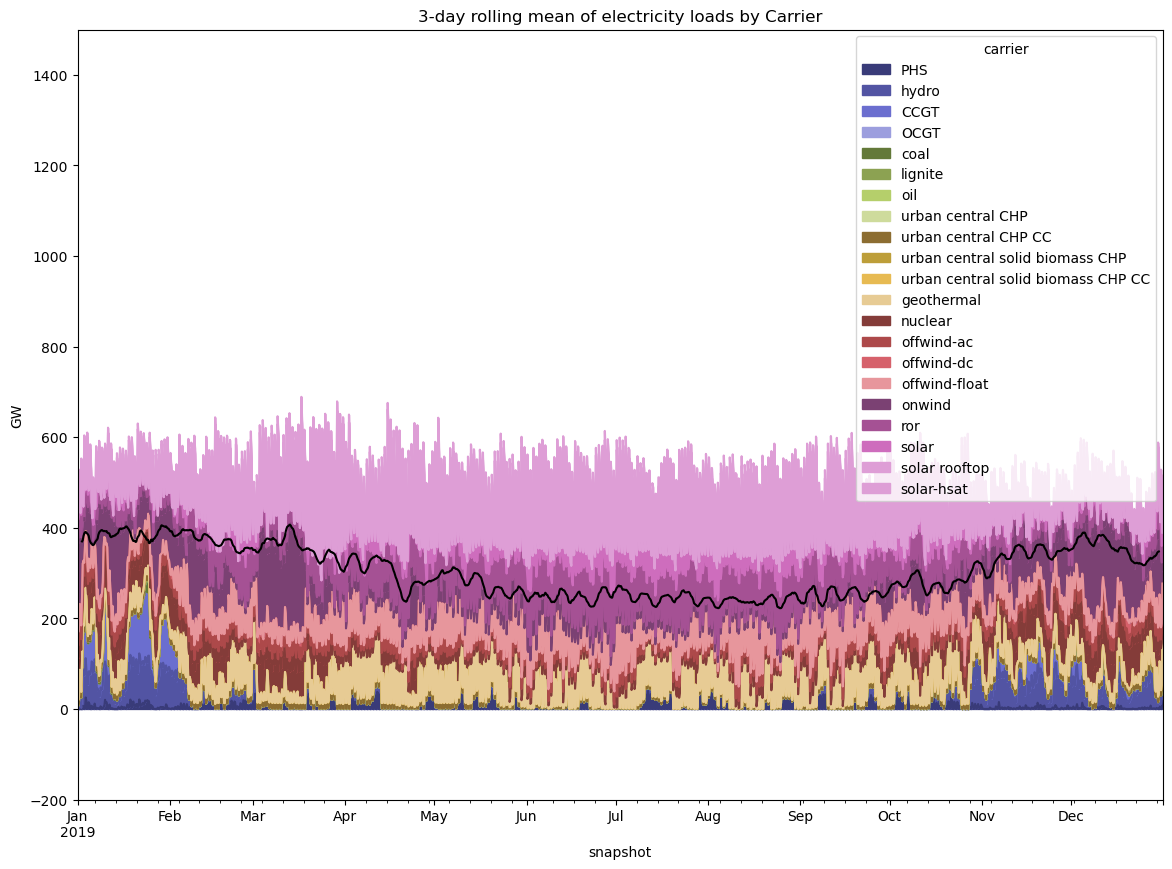

In [ ]:
all_dispatch_plus_load_electric_test(BAU_bev_30_2030)

In [ ]:
BAU_no_flex_2050.statistics().loc['Generator'] #98 MW of geothermal installed 
#supply of 8.14x10^5 MWh = .8TWh
BAU_no_flex_2050.generators.p_nom_opt[BAU_no_flex_2050.generators[BAU_no_flex_2050.generators.carrier == 'geothermal'].index]

Generator
IT0 0 geothermal    98.0
Name: p_nom_opt, dtype: float64

In [ ]:
BAU_no_flex_2050.generators_t.p_nom_opt[BAU_no_flex_2050.generators[BAU_no_flex_2050.generators.carrier == 'geothermal'].index]

AttributeError: p_nom_opt